In [ ]:
eta = 0.1
optimizer_lr = 1e-5 # try 1e-5 from dim=2

dim = 10
n_center = 9
l = 5

num_layers = 30
width = 256

n_max_mirror_iterations= 10       # num mirror steps (for the frist and second)
n_max_iterations=6000        # max inner steps

num_samples = 10000         # number of theta generated for training
num_samples_test =  8192 # samples to estimate KL
import math
verbose = True
set_seed = 114540 # seed not used.
exp_number = 0 # [0, 1, 2, 3, 4]
pretrain_factor = 100

outer_lr_final_factor = 1e0
outer_eta_final_factor = 1e0
import math
outer_lr_factor = pow(math.e, math.log(outer_lr_final_factor)/n_max_mirror_iterations)
outer_eta_factor = pow(math.e, math.log(outer_eta_final_factor)/n_max_mirror_iterations)

In [ ]:
!pip install normflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normflows: filename=normflows-1.7.3-py2.py3-none-any.whl size=87245 sha256=5c8a0fbba7844563df1e67b5b8e9374b076b40eafd5288afc596060a560d2b9d
  Stored in directory: /root/.cache/pip/wheels/08/b1/a6/f018e29f12dc6251793263911d14764ddad0a6844f7b024007
Successfully built normflows


In [ ]:
import numpy as np
import zlib
from multipledispatch import dispatch
import torch
import random

class RandomManager:
    '''
    Manage random using crc32 checksum for seeds generating
    '''

    @staticmethod
    def _get_crc32_seed(_str):
        _bstr = str.encode(_str)
        return zlib.crc32(_bstr)

    def _make_str(self, *args):
        return '@'.join(map(str, args))

    def __init__(self, *args):
        self._str = self._make_str(*args)

    def get_seed(self, *postfixes):
        _str = self._str + self._make_str(*postfixes)
        return self._get_crc32_seed(_str)

    def seed_random(self, *postfixes):
        rnd_postfixes = ('random',) + postfixes
        random.seed(self.get_seed(*rnd_postfixes))
        return self

    def seed_torch(self, *postfixes):
        torch_postfixes = ('pytorch',) + postfixes
        torch.manual_seed(self.get_seed(*torch_postfixes))
        return self

    def seed_numpy(self, *postfixes):
        np_postfixes = ('numpy',) + postfixes
        np.random.seed(self.get_seed(*np_postfixes))
        return self

    def seed(self, *postfixes):
        return self.seed_random(*postfixes).seed_numpy(*postfixes).seed_torch(*postfixes)

def get_random_manager(*args):
    return RandomManager(*args)

In [ ]:
# Import required packages
import torch
import numpy as np
import normflows as nf
import os
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import torch.nn.functional as F
import torch.distributions as TD
import pandas as pd
import seaborn as sb
import torch.nn as nn
import shutil
import gc
import copy
import time
from scipy.optimize import linear_sum_assignment

In [ ]:
torch.manual_seed(114514)
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

In [ ]:
def random_centers_distrib_generator(n, n_rand, target_span, std, device='cpu', dtype=torch.float32):
    centers_sample_distrib = TD.Uniform(-target_span, target_span)
    centers = centers_sample_distrib.sample((n_rand, n)).to(device, dtype)
    comp = TD.Independent(TD.Normal(centers, torch.tensor([std,]).to(device, dtype)), 1)
    mix = TD.Categorical(torch.ones(n_rand,).to(device, dtype))
    target = TD.MixtureSameFamily(mix, comp)
    return target

def random_project(input_data, p = 2, random_seed = 114514):
  import torch
# input_data n by m
# random_matrix m by p
# random_projected = 1/sqrt(p) * input_data %*% random_matrix
  torch.manual_seed(random_seed)
  m = input_data.shape[1]
  random_mx = torch.randn((m, p))
  projected = (1/torch.sqrt(torch.tensor(p)))*torch.matmul(input_data, random_mx)
  return projected

def plot_two_data(target_dist, model_transform):
  import matplotlib.pyplot as plt
  import pandas as pd
  import seaborn as sb

  df_1 = pd.DataFrame(random_project(target_dist)).astype("float")
  df_2 =  pd.DataFrame(random_project(model_transform)).astype("float")

  df_1["type"] = "target dist"
  df_2["type"] = "model transform"
  df_all = pd.concat([df_1, df_2], ignore_index=True)
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)
  sns_plot = sb.jointplot(data=df_all, x="dim_0", y="dim_1", hue="type", kind="kde")
  return sns_plot

<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


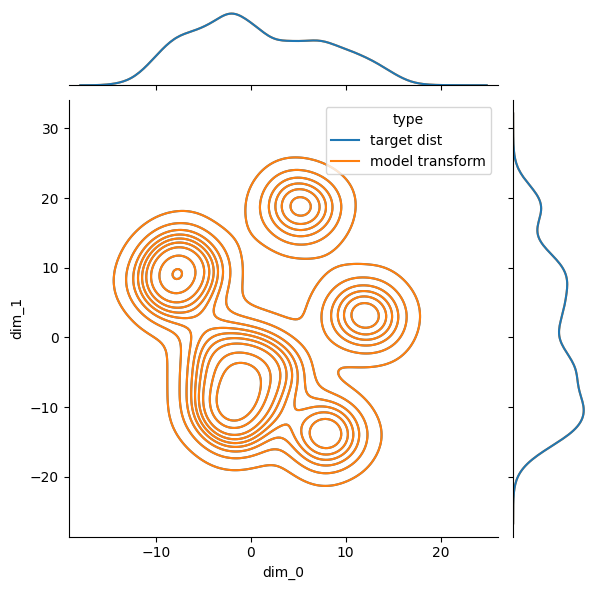

In [ ]:
r_m = get_random_manager('uran', dim, exp_number)
r_m.seed()

stationary_dist = random_centers_distrib_generator(n = dim, n_rand = n_center, target_span = l, std = 1, device=device, dtype=torch.float32)
target_samples = stationary_dist.sample((5000,))
plot_two_data(target_samples.cpu().detach(), target_samples.cpu().detach())

In [ ]:
kld1_hist = np.array([])
kld2_hist = np.array([])



trail_num = exp_number
torch.manual_seed(527)

# target_pretrain = TD.MultivariateNormal(
#     torch.zeros(dim).to(device), pretrain_factor * torch.eye(dim).to(device))
target_pretrain = TD.Uniform(-10, 10)
# Define 2D Gaussian base distribution
base = nf.distributions.DiagGaussian(dim, trainable=False)
# Define list of flows
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([int(dim/2), width, width, width, dim], init_zeros=True )
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(dim, mode='swap'))

# for i in range(num_layers):
#     flows += [nf.flows.AutoregressiveRationalQuadraticSpline(dim, 2, width)]
#     flows += [nf.flows.LULinearPermute(dim)]

# Construct flow model
model = nf.NormalizingFlow(base, flows).to(device)
optimizer1 = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

for it in tqdm(range(100)):
    optimizer1.zero_grad()

    # Get training samples
    # x = target_pretrain.sample((num_samples,)).to(device)
    x = target_pretrain.sample((num_samples, dim)).to(device)

    # Compute loss
    loss = model.forward_kld(x)

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer1.step()

    if it % 100 == 99:
      clear_output(wait=True)
      print('Loss:', loss.item())


100%|██████████| 100/100 [00:10<00:00,  9.73it/s]

Loss: 31.64579200744629


<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


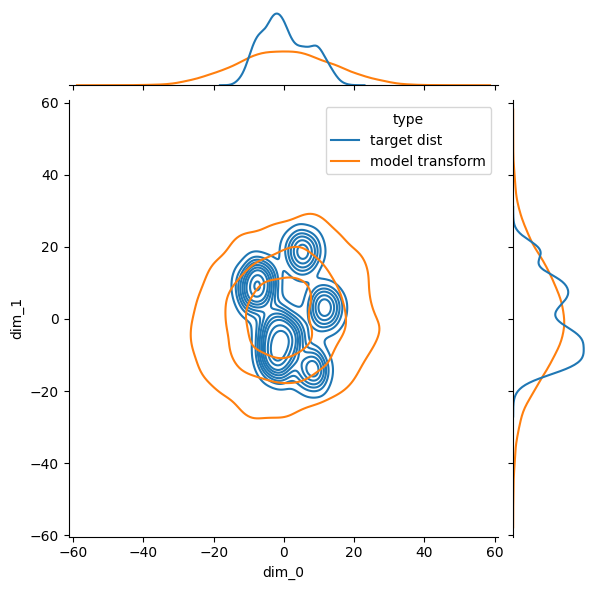

In [ ]:
target_samples = stationary_dist.sample((5000,))
model_samples, _ = model.sample(5000)
plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())

  2%|▏         | 100/6000 [00:29<31:34,  3.12it/s]

trail: 0 m step: 0 Loss: 63.68984603881836  L_n: 46.38203048706055  kld: 1.7307815551757812 KLD1: 46.0477409362793 KLD2: 9.69664478302002


  3%|▎         | 200/6000 [00:58<31:35,  3.06it/s]

trail: 0 m step: 0 Loss: 61.62885284423828  L_n: 43.18910217285156  kld: 1.8439750671386719 KLD1: 43.379791259765625 KLD2: 9.479321479797363


  5%|▌         | 300/6000 [01:28<31:31,  3.01it/s]

trail: 0 m step: 0 Loss: 61.24394989013672  L_n: 42.25770568847656  kld: 1.8986244201660156 KLD1: 41.84243392944336 KLD2: 9.301793098449707


  7%|▋         | 400/6000 [01:58<31:26,  2.97it/s]

trail: 0 m step: 0 Loss: 59.57405471801758  L_n: 40.54033660888672  kld: 1.903371810913086 KLD1: 40.94763946533203 KLD2: 9.060443878173828


  8%|▊         | 500/6000 [02:29<31:09,  2.94it/s]

trail: 0 m step: 0 Loss: 58.827816009521484  L_n: 39.46748352050781  kld: 1.9360332489013672 KLD1: 39.78550338745117 KLD2: 8.822003364562988


 10%|█         | 600/6000 [02:59<30:45,  2.93it/s]

trail: 0 m step: 0 Loss: 58.7127571105957  L_n: 38.57880401611328  kld: 2.013395309448242 KLD1: 38.27536392211914 KLD2: 8.59237289428711


 12%|█▏        | 700/6000 [03:30<30:22,  2.91it/s]

trail: 0 m step: 0 Loss: 58.37211227416992  L_n: 37.70085906982422  kld: 2.0671253204345703 KLD1: 37.625274658203125 KLD2: 8.448267936706543


 13%|█▎        | 800/6000 [04:02<30:07,  2.88it/s]

trail: 0 m step: 0 Loss: 57.257118225097656  L_n: 36.522369384765625  kld: 2.073474884033203 KLD1: 36.807167053222656 KLD2: 8.2741060256958


 15%|█▌        | 900/6000 [04:33<29:30,  2.88it/s]

trail: 0 m step: 0 Loss: 56.95891189575195  L_n: 36.00697326660156  kld: 2.095193862915039 KLD1: 36.218544006347656 KLD2: 8.1409912109375


 17%|█▋        | 1000/6000 [05:05<29:02,  2.87it/s]

trail: 0 m step: 0 Loss: 56.619998931884766  L_n: 35.31218719482422  kld: 2.1307811737060547 KLD1: 35.587215423583984 KLD2: 8.024993896484375


 18%|█▊        | 1100/6000 [05:36<28:31,  2.86it/s]

trail: 0 m step: 0 Loss: 56.64461135864258  L_n: 35.14244079589844  kld: 2.150217056274414 KLD1: 34.99664306640625 KLD2: 7.9048027992248535


 20%|██        | 1200/6000 [06:08<27:58,  2.86it/s]

trail: 0 m step: 0 Loss: 56.22367858886719  L_n: 34.61193084716797  kld: 2.161174774169922 KLD1: 34.845027923583984 KLD2: 7.844714641571045


 22%|██▏       | 1300/6000 [06:39<27:23,  2.86it/s]

trail: 0 m step: 0 Loss: 55.89358139038086  L_n: 34.106224060058594  kld: 2.1787357330322266 KLD1: 34.34804916381836 KLD2: 7.778153896331787


 23%|██▎       | 1400/6000 [07:11<26:49,  2.86it/s]

trail: 0 m step: 0 Loss: 55.83761978149414  L_n: 33.76835632324219  kld: 2.2069263458251953 KLD1: 33.74256896972656 KLD2: 7.7106218338012695


 25%|██▌       | 1500/6000 [07:42<26:07,  2.87it/s]

trail: 0 m step: 0 Loss: 55.31616973876953  L_n: 33.5506706237793  kld: 2.1765499114990234 KLD1: 33.70653533935547 KLD2: 7.732346534729004


 27%|██▋       | 1600/6000 [08:14<25:38,  2.86it/s]

trail: 0 m step: 0 Loss: 55.46488571166992  L_n: 33.461273193359375  kld: 2.2003612518310547 KLD1: 33.34161376953125 KLD2: 7.642985820770264


 28%|██▊       | 1700/6000 [08:46<25:06,  2.85it/s]

trail: 0 m step: 0 Loss: 55.27821350097656  L_n: 33.098114013671875  kld: 2.2180099487304688 KLD1: 32.77861404418945 KLD2: 7.592929363250732


 30%|███       | 1800/6000 [09:17<24:32,  2.85it/s]

trail: 0 m step: 0 Loss: 54.55721664428711  L_n: 32.45465087890625  kld: 2.210256576538086 KLD1: 32.49397277832031 KLD2: 7.588484287261963


 32%|███▏      | 1900/6000 [09:49<23:58,  2.85it/s]

trail: 0 m step: 0 Loss: 54.658912658691406  L_n: 32.501319885253906  kld: 2.21575927734375 KLD1: 32.56082534790039 KLD2: 7.586437225341797


 33%|███▎      | 2000/6000 [10:21<23:19,  2.86it/s]

trail: 0 m step: 0 Loss: 54.57396697998047  L_n: 32.15174865722656  kld: 2.2422218322753906 KLD1: 31.90534019470215 KLD2: 7.482143402099609


 35%|███▌      | 2100/6000 [10:52<22:45,  2.86it/s]

trail: 0 m step: 0 Loss: 54.023019790649414  L_n: 31.827699661254883  kld: 2.219532012939453 KLD1: 32.15161895751953 KLD2: 7.460297584533691


 37%|███▋      | 2200/6000 [11:24<22:11,  2.85it/s]

trail: 0 m step: 0 Loss: 54.176259994506836  L_n: 31.803442001342773  kld: 2.2372817993164062 KLD1: 31.917285919189453 KLD2: 7.424784183502197


 38%|███▊      | 2300/6000 [11:56<21:37,  2.85it/s]

trail: 0 m step: 0 Loss: 54.2137451171875  L_n: 31.65799331665039  kld: 2.255575180053711 KLD1: 31.51506233215332 KLD2: 7.415485858917236


 40%|████      | 2400/6000 [12:27<21:05,  2.84it/s]

trail: 0 m step: 0 Loss: 53.86403274536133  L_n: 31.254398345947266  kld: 2.2609634399414062 KLD1: 31.347318649291992 KLD2: 7.373452186584473


 42%|████▏     | 2500/6000 [12:59<20:26,  2.85it/s]

trail: 0 m step: 0 Loss: 54.13204383850098  L_n: 31.531373977661133  kld: 2.2600669860839844 KLD1: 31.253705978393555 KLD2: 7.3653082847595215


 43%|████▎     | 2600/6000 [13:31<19:53,  2.85it/s]

trail: 0 m step: 0 Loss: 54.16830253601074  L_n: 31.438295364379883  kld: 2.273000717163086 KLD1: 31.069917678833008 KLD2: 7.382411479949951


 45%|████▌     | 2700/6000 [14:03<19:18,  2.85it/s]

trail: 0 m step: 0 Loss: 53.925886154174805  L_n: 31.234922409057617  kld: 2.2690963745117188 KLD1: 31.01713752746582 KLD2: 7.3293046951293945


 47%|████▋     | 2800/6000 [14:34<18:45,  2.84it/s]

trail: 0 m step: 0 Loss: 53.672542572021484  L_n: 31.384201049804688  kld: 2.2288341522216797 KLD1: 31.567249298095703 KLD2: 7.307914733886719


 48%|████▊     | 2900/6000 [15:06<18:07,  2.85it/s]

trail: 0 m step: 0 Loss: 53.83103942871094  L_n: 30.770660400390625  kld: 2.3060379028320312 KLD1: 30.63264274597168 KLD2: 7.2854719161987305


 50%|█████     | 3000/6000 [15:38<17:32,  2.85it/s]

trail: 0 m step: 0 Loss: 53.60458946228027  L_n: 30.91570472717285  kld: 2.268888473510742 KLD1: 30.88552474975586 KLD2: 7.252970218658447


 52%|█████▏    | 3100/6000 [16:09<16:58,  2.85it/s]

trail: 0 m step: 0 Loss: 53.185909271240234  L_n: 31.054943084716797  kld: 2.2130966186523438 KLD1: 31.444868087768555 KLD2: 7.2544074058532715


 53%|█████▎    | 3200/6000 [16:41<16:17,  2.87it/s]

trail: 0 m step: 0 Loss: 53.670854568481445  L_n: 30.96673011779785  kld: 2.2704124450683594 KLD1: 30.800262451171875 KLD2: 7.248226165771484


 55%|█████▌    | 3300/6000 [17:13<15:46,  2.85it/s]

trail: 0 m step: 0 Loss: 53.39455986022949  L_n: 30.79886817932129  kld: 2.2595691680908203 KLD1: 30.91875457763672 KLD2: 7.223353862762451


 57%|█████▋    | 3400/6000 [17:44<15:06,  2.87it/s]

trail: 0 m step: 0 Loss: 53.56837463378906  L_n: 30.957500457763672  kld: 2.261087417602539 KLD1: 30.939790725708008 KLD2: 7.204079627990723


 58%|█████▊    | 3500/6000 [18:16<14:34,  2.86it/s]

trail: 0 m step: 0 Loss: 53.269813537597656  L_n: 30.77862548828125  kld: 2.2491188049316406 KLD1: 30.924131393432617 KLD2: 7.18004035949707


 60%|██████    | 3600/6000 [18:48<14:01,  2.85it/s]

trail: 0 m step: 0 Loss: 53.60044288635254  L_n: 30.670068740844727  kld: 2.2930374145507812 KLD1: 30.514856338500977 KLD2: 7.162117958068848


 62%|██████▏   | 3700/6000 [19:19<13:27,  2.85it/s]

trail: 0 m step: 0 Loss: 53.33836364746094  L_n: 30.536048889160156  kld: 2.280231475830078 KLD1: 30.50251579284668 KLD2: 7.134011745452881


 63%|██████▎   | 3800/6000 [19:51<12:53,  2.85it/s]

trail: 0 m step: 0 Loss: 53.22410774230957  L_n: 30.519392013549805  kld: 2.2704715728759766 KLD1: 30.702537536621094 KLD2: 7.16251802444458


 65%|██████▌   | 3900/6000 [20:23<12:14,  2.86it/s]

trail: 0 m step: 0 Loss: 53.77857780456543  L_n: 30.935579299926758  kld: 2.284299850463867 KLD1: 30.525711059570312 KLD2: 7.157374858856201


 67%|██████▋   | 4000/6000 [20:54<11:40,  2.85it/s]

trail: 0 m step: 0 Loss: 53.20046043395996  L_n: 30.41136360168457  kld: 2.278909683227539 KLD1: 30.593280792236328 KLD2: 7.106382846832275


 68%|██████▊   | 4100/6000 [21:26<11:04,  2.86it/s]

trail: 0 m step: 0 Loss: 53.18155288696289  L_n: 30.679054260253906  kld: 2.2502498626708984 KLD1: 30.734739303588867 KLD2: 7.12232780456543


 70%|███████   | 4200/6000 [21:58<10:31,  2.85it/s]

trail: 0 m step: 0 Loss: 53.18222236633301  L_n: 30.423547744750977  kld: 2.275867462158203 KLD1: 30.55607032775879 KLD2: 7.1297287940979


 72%|███████▏  | 4300/6000 [22:29<09:53,  2.86it/s]

trail: 0 m step: 0 Loss: 53.43676567077637  L_n: 30.51825523376465  kld: 2.291851043701172 KLD1: 30.352678298950195 KLD2: 7.093287467956543


 73%|███████▎  | 4400/6000 [23:01<09:20,  2.86it/s]

trail: 0 m step: 0 Loss: 53.38535690307617  L_n: 30.536521911621094  kld: 2.284883499145508 KLD1: 30.484567642211914 KLD2: 7.068684101104736


 75%|███████▌  | 4500/6000 [23:33<08:46,  2.85it/s]

trail: 0 m step: 0 Loss: 53.39864540100098  L_n: 30.54960060119629  kld: 2.2849044799804688 KLD1: 30.363821029663086 KLD2: 7.098910808563232


 77%|███████▋  | 4600/6000 [24:04<08:09,  2.86it/s]

trail: 0 m step: 0 Loss: 53.05620193481445  L_n: 30.20832061767578  kld: 2.284788131713867 KLD1: 30.365131378173828 KLD2: 7.078802108764648


 78%|███████▊  | 4700/6000 [24:36<07:35,  2.85it/s]

trail: 0 m step: 0 Loss: 53.22089385986328  L_n: 30.166275024414062  kld: 2.305461883544922 KLD1: 30.23396873474121 KLD2: 7.085021495819092


 80%|████████  | 4800/6000 [25:08<07:00,  2.86it/s]

trail: 0 m step: 0 Loss: 52.69729232788086  L_n: 30.133853912353516  kld: 2.2563438415527344 KLD1: 30.776948928833008 KLD2: 7.0646138191223145


 82%|████████▏ | 4900/6000 [25:39<06:26,  2.85it/s]

trail: 0 m step: 0 Loss: 53.32192611694336  L_n: 30.411331176757812  kld: 2.2910594940185547 KLD1: 30.292760848999023 KLD2: 7.049785137176514


 83%|████████▎ | 5000/6000 [26:11<05:49,  2.86it/s]

trail: 0 m step: 0 Loss: 53.11254119873047  L_n: 30.314956665039062  kld: 2.2797584533691406 KLD1: 30.24676513671875 KLD2: 7.048074722290039


 85%|████████▌ | 5100/6000 [26:43<05:16,  2.85it/s]

trail: 0 m step: 0 Loss: 53.16516304016113  L_n: 30.176156997680664  kld: 2.298900604248047 KLD1: 30.25551414489746 KLD2: 7.081785678863525


 87%|████████▋ | 5200/6000 [27:14<04:39,  2.86it/s]

trail: 0 m step: 0 Loss: 53.11285972595215  L_n: 30.222978591918945  kld: 2.2889881134033203 KLD1: 30.414871215820312 KLD2: 7.03183126449585


 88%|████████▊ | 5300/6000 [27:46<04:05,  2.86it/s]

trail: 0 m step: 0 Loss: 53.27180480957031  L_n: 30.261512756347656  kld: 2.3010292053222656 KLD1: 30.132627487182617 KLD2: 7.026665210723877


 90%|█████████ | 5400/6000 [28:18<03:30,  2.85it/s]

trail: 0 m step: 0 Loss: 53.18728446960449  L_n: 30.180959701538086  kld: 2.3006324768066406 KLD1: 30.19550323486328 KLD2: 7.065176486968994


 92%|█████████▏| 5500/6000 [28:49<02:55,  2.85it/s]

trail: 0 m step: 0 Loss: 53.33185958862305  L_n: 30.296390533447266  kld: 2.303546905517578 KLD1: 30.20416259765625 KLD2: 7.000466823577881


 93%|█████████▎| 5600/6000 [29:21<02:20,  2.86it/s]

trail: 0 m step: 0 Loss: 53.40264129638672  L_n: 30.233924865722656  kld: 2.3168716430664062 KLD1: 29.958139419555664 KLD2: 7.012820243835449


 95%|█████████▌| 5700/6000 [29:53<01:44,  2.86it/s]

trail: 0 m step: 0 Loss: 52.95499038696289  L_n: 29.917022705078125  kld: 2.3037967681884766 KLD1: 30.053987503051758 KLD2: 7.0295233726501465


 97%|█████████▋| 5800/6000 [30:24<01:10,  2.85it/s]

trail: 0 m step: 0 Loss: 53.09316062927246  L_n: 30.031789779663086  kld: 2.3061370849609375 KLD1: 30.038362503051758 KLD2: 6.992317199707031


 98%|█████████▊| 5900/6000 [30:56<00:35,  2.86it/s]

trail: 0 m step: 0 Loss: 53.47096061706543  L_n: 30.184598922729492  kld: 2.3286361694335938 KLD1: 29.861225128173828 KLD2: 7.027701377868652


100%|██████████| 6000/6000 [31:28<00:00,  3.18it/s]

trail: 0 m step: 0 Loss: 53.0026798248291  L_n: 29.90953254699707  kld: 2.309314727783203 KLD1: 30.07270622253418 KLD2: 7.0059967041015625



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


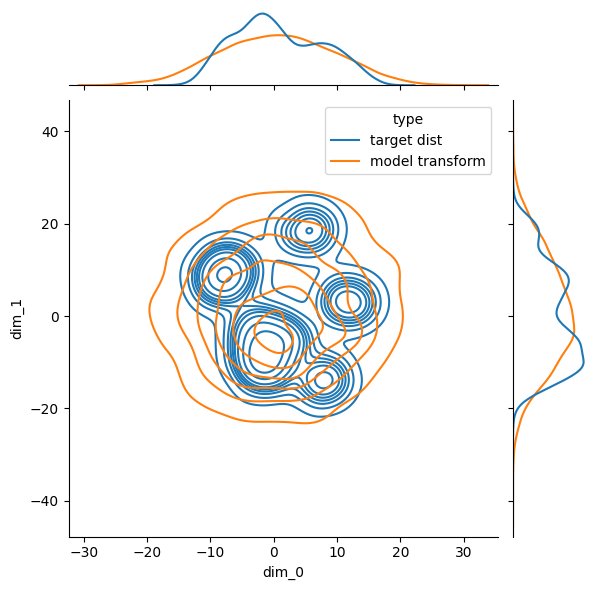

trail: 0 m step: 0 kl_test: 29.929370880126953


  2%|▏         | 100/6000 [00:31<34:34,  2.84it/s]

trail: 0 m step: 1 Loss: 23.23004913330078  L_n: 18.760883331298828  kld: 0.4469165802001953 KLD1: 18.59062385559082 KLD2: 5.470541954040527


  3%|▎         | 200/6000 [01:03<33:58,  2.85it/s]

trail: 0 m step: 1 Loss: 22.507123947143555  L_n: 17.83684730529785  kld: 0.4670276641845703 KLD1: 18.114580154418945 KLD2: 5.341684341430664


  5%|▌         | 300/6000 [01:35<33:22,  2.85it/s]

trail: 0 m step: 1 Loss: 22.822593688964844  L_n: 17.84389877319336  kld: 0.49786949157714844 KLD1: 17.429100036621094 KLD2: 5.251307010650635


  7%|▋         | 400/6000 [02:07<32:55,  2.83it/s]

trail: 0 m step: 1 Loss: 22.12200164794922  L_n: 17.133216857910156  kld: 0.49887847900390625 KLD1: 17.294647216796875 KLD2: 5.132985591888428


  8%|▊         | 500/6000 [02:38<32:19,  2.84it/s]

trail: 0 m step: 1 Loss: 22.104148864746094  L_n: 17.118186950683594  kld: 0.49859619140625 KLD1: 17.286649703979492 KLD2: 5.054354190826416


 10%|█         | 600/6000 [03:10<31:47,  2.83it/s]

trail: 0 m step: 1 Loss: 22.181737899780273  L_n: 17.002103805541992  kld: 0.5179634094238281 KLD1: 16.88985824584961 KLD2: 5.002071857452393


 12%|█▏        | 700/6000 [03:42<31:11,  2.83it/s]

trail: 0 m step: 1 Loss: 22.103727340698242  L_n: 16.83061408996582  kld: 0.5273113250732422 KLD1: 16.828662872314453 KLD2: 4.988743782043457


 13%|█▎        | 800/6000 [04:14<30:34,  2.84it/s]

trail: 0 m step: 1 Loss: 21.751392364501953  L_n: 16.57555389404297  kld: 0.5175838470458984 KLD1: 16.854936599731445 KLD2: 4.936425685882568


 15%|█▌        | 900/6000 [04:46<29:56,  2.84it/s]

trail: 0 m step: 1 Loss: 21.898696899414062  L_n: 16.618907928466797  kld: 0.5279788970947266 KLD1: 16.53492546081543 KLD2: 4.896284103393555


 17%|█▋        | 1000/6000 [05:18<29:30,  2.82it/s]

trail: 0 m step: 1 Loss: 21.769277572631836  L_n: 16.4442081451416  kld: 0.5325069427490234 KLD1: 16.579111099243164 KLD2: 4.880431652069092


 18%|█▊        | 1100/6000 [05:50<28:42,  2.85it/s]

trail: 0 m step: 1 Loss: 21.881006240844727  L_n: 16.394861221313477  kld: 0.548614501953125 KLD1: 16.24725341796875 KLD2: 4.82236385345459


 20%|██        | 1200/6000 [06:22<28:14,  2.83it/s]

trail: 0 m step: 1 Loss: 21.79825782775879  L_n: 16.245527267456055  kld: 0.5552730560302734 KLD1: 16.171045303344727 KLD2: 4.802742004394531


 22%|██▏       | 1300/6000 [06:53<27:32,  2.84it/s]

trail: 0 m step: 1 Loss: 21.503311157226562  L_n: 15.938316345214844  kld: 0.5564994812011719 KLD1: 16.12702178955078 KLD2: 4.792578220367432


 23%|██▎       | 1400/6000 [07:25<27:04,  2.83it/s]

trail: 0 m step: 1 Loss: 21.67218589782715  L_n: 16.012739181518555  kld: 0.5659446716308594 KLD1: 15.955002784729004 KLD2: 4.779102802276611


 25%|██▌       | 1500/6000 [07:57<26:30,  2.83it/s]

trail: 0 m step: 1 Loss: 21.499622344970703  L_n: 16.013648986816406  kld: 0.5485973358154297 KLD1: 16.102420806884766 KLD2: 4.81679105758667


 27%|██▋       | 1600/6000 [08:29<25:52,  2.83it/s]

trail: 0 m step: 1 Loss: 21.703767776489258  L_n: 16.10365867614746  kld: 0.5600109100341797 KLD1: 16.03855323791504 KLD2: 4.756503105163574


 28%|██▊       | 1700/6000 [09:01<25:22,  2.82it/s]

trail: 0 m step: 1 Loss: 21.566776275634766  L_n: 16.01152801513672  kld: 0.5555248260498047 KLD1: 15.937644958496094 KLD2: 4.747939109802246


 30%|███       | 1800/6000 [09:33<24:38,  2.84it/s]

trail: 0 m step: 1 Loss: 21.390518188476562  L_n: 15.82891845703125  kld: 0.5561599731445312 KLD1: 15.831221580505371 KLD2: 4.769814968109131


 32%|███▏      | 1900/6000 [10:05<24:06,  2.83it/s]

trail: 0 m step: 1 Loss: 21.458736419677734  L_n: 15.725151062011719  kld: 0.5733585357666016 KLD1: 15.756831169128418 KLD2: 4.78279447555542


 33%|███▎      | 2000/6000 [10:37<23:31,  2.83it/s]

trail: 0 m step: 1 Loss: 21.58267593383789  L_n: 15.81698989868164  kld: 0.576568603515625 KLD1: 15.651179313659668 KLD2: 4.72089147567749


 35%|███▌      | 2100/6000 [11:09<22:56,  2.83it/s]

trail: 0 m step: 1 Loss: 21.303665161132812  L_n: 15.721561431884766  kld: 0.5582103729248047 KLD1: 15.958893775939941 KLD2: 4.7137932777404785


 37%|███▋      | 2200/6000 [11:41<22:21,  2.83it/s]

trail: 0 m step: 1 Loss: 21.4012451171875  L_n: 15.689079284667969  kld: 0.5712165832519531 KLD1: 15.850133895874023 KLD2: 4.699493408203125


 38%|███▊      | 2300/6000 [12:13<21:42,  2.84it/s]

trail: 0 m step: 1 Loss: 21.309417724609375  L_n: 15.5338134765625  kld: 0.5775604248046875 KLD1: 15.6070556640625 KLD2: 4.713067054748535


 40%|████      | 2400/6000 [12:44<21:07,  2.84it/s]

trail: 0 m step: 1 Loss: 21.278757095336914  L_n: 15.512880325317383  kld: 0.5765876770019531 KLD1: 15.683863639831543 KLD2: 4.696168899536133


 42%|████▏     | 2500/6000 [13:16<20:32,  2.84it/s]

trail: 0 m step: 1 Loss: 21.59920310974121  L_n: 15.781885147094727  kld: 0.5817317962646484 KLD1: 15.590642929077148 KLD2: 4.706640720367432


 43%|████▎     | 2600/6000 [13:48<19:57,  2.84it/s]

trail: 0 m step: 1 Loss: 21.63716697692871  L_n: 15.818971633911133  kld: 0.5818195343017578 KLD1: 15.527055740356445 KLD2: 4.738880157470703


 45%|████▌     | 2700/6000 [14:20<19:25,  2.83it/s]

trail: 0 m step: 1 Loss: 21.516897201538086  L_n: 15.659639358520508  kld: 0.5857257843017578 KLD1: 15.485800743103027 KLD2: 4.694626331329346


 47%|████▋     | 2800/6000 [14:52<18:48,  2.83it/s]

trail: 0 m step: 1 Loss: 21.333171844482422  L_n: 15.750972747802734  kld: 0.5582199096679688 KLD1: 15.748686790466309 KLD2: 4.708122253417969


 48%|████▊     | 2900/6000 [15:24<18:12,  2.84it/s]

trail: 0 m step: 1 Loss: 21.5654296875  L_n: 15.44705581665039  kld: 0.6118373870849609 KLD1: 15.278355598449707 KLD2: 4.69529390335083


 50%|█████     | 3000/6000 [15:56<17:37,  2.84it/s]

trail: 0 m step: 1 Loss: 21.36236000061035  L_n: 15.520818710327148  kld: 0.5841541290283203 KLD1: 15.49581241607666 KLD2: 4.682344436645508


 52%|█████▏    | 3100/6000 [16:27<17:04,  2.83it/s]

trail: 0 m step: 1 Loss: 21.02988624572754  L_n: 15.49165153503418  kld: 0.5538234710693359 KLD1: 15.78400707244873 KLD2: 4.693404197692871


 53%|█████▎    | 3200/6000 [16:59<16:28,  2.83it/s]

trail: 0 m step: 1 Loss: 21.380672454833984  L_n: 15.50863265991211  kld: 0.5872039794921875 KLD1: 15.411907196044922 KLD2: 4.695061683654785


 55%|█████▌    | 3300/6000 [17:31<15:49,  2.84it/s]

trail: 0 m step: 1 Loss: 21.2288875579834  L_n: 15.521280288696289  kld: 0.5707607269287109 KLD1: 15.63621997833252 KLD2: 4.69443416595459


 57%|█████▋    | 3400/6000 [18:03<15:16,  2.84it/s]

trail: 0 m step: 1 Loss: 21.407445907592773  L_n: 15.738119125366211  kld: 0.5669326782226562 KLD1: 15.719415664672852 KLD2: 4.6907734870910645


 58%|█████▊    | 3500/6000 [18:35<14:44,  2.83it/s]

trail: 0 m step: 1 Loss: 21.227643966674805  L_n: 15.517309188842773  kld: 0.5710334777832031 KLD1: 15.657724380493164 KLD2: 4.686259746551514


 60%|██████    | 3600/6000 [19:07<14:06,  2.83it/s]

trail: 0 m step: 1 Loss: 21.398239135742188  L_n: 15.46844482421875  kld: 0.5929794311523438 KLD1: 15.37454605102539 KLD2: 4.683931350708008


 62%|██████▏   | 3700/6000 [19:39<13:30,  2.84it/s]

trail: 0 m step: 1 Loss: 21.260740280151367  L_n: 15.431882858276367  kld: 0.5828857421875 KLD1: 15.419403076171875 KLD2: 4.6744465827941895


 63%|██████▎   | 3800/6000 [20:11<12:53,  2.85it/s]

trail: 0 m step: 1 Loss: 21.238731384277344  L_n: 15.428985595703125  kld: 0.5809745788574219 KLD1: 15.445425033569336 KLD2: 4.698280334472656


 65%|██████▌   | 3900/6000 [20:42<12:19,  2.84it/s]

trail: 0 m step: 1 Loss: 21.443191528320312  L_n: 15.599533081054688  kld: 0.5843658447265625 KLD1: 15.479488372802734 KLD2: 4.693717956542969


 67%|██████▋   | 4000/6000 [21:14<11:46,  2.83it/s]

trail: 0 m step: 1 Loss: 21.25212860107422  L_n: 15.423194885253906  kld: 0.5828933715820312 KLD1: 15.411752700805664 KLD2: 4.667258262634277


 68%|██████▊   | 4100/6000 [21:46<11:09,  2.84it/s]

trail: 0 m step: 1 Loss: 21.10329818725586  L_n: 15.410091400146484  kld: 0.5693206787109375 KLD1: 15.611088752746582 KLD2: 4.678646564483643


 70%|███████   | 4200/6000 [22:18<10:33,  2.84it/s]

trail: 0 m step: 1 Loss: 21.082080841064453  L_n: 15.250286102294922  kld: 0.5831794738769531 KLD1: 15.385794639587402 KLD2: 4.690849304199219


 72%|███████▏  | 4300/6000 [22:50<09:57,  2.84it/s]

trail: 0 m step: 1 Loss: 21.35978889465332  L_n: 15.43531608581543  kld: 0.5924472808837891 KLD1: 15.318699836730957 KLD2: 4.661683559417725


 73%|███████▎  | 4400/6000 [23:22<09:24,  2.83it/s]

trail: 0 m step: 1 Loss: 21.259260177612305  L_n: 15.470590591430664  kld: 0.5788669586181641 KLD1: 15.475534439086914 KLD2: 4.647387504577637


 75%|███████▌  | 4500/6000 [23:54<08:50,  2.83it/s]

trail: 0 m step: 1 Loss: 21.308935165405273  L_n: 15.46251106262207  kld: 0.5846424102783203 KLD1: 15.40480899810791 KLD2: 4.67264461517334


 77%|███████▋  | 4600/6000 [24:26<08:14,  2.83it/s]

trail: 0 m step: 1 Loss: 21.06134796142578  L_n: 15.225337982177734  kld: 0.5836009979248047 KLD1: 15.430133819580078 KLD2: 4.661191940307617


 78%|███████▊  | 4700/6000 [24:57<07:38,  2.84it/s]

trail: 0 m step: 1 Loss: 21.2474308013916  L_n: 15.263200759887695  kld: 0.5984230041503906 KLD1: 15.321249961853027 KLD2: 4.671015739440918


 80%|████████  | 4800/6000 [25:29<07:03,  2.83it/s]

trail: 0 m step: 1 Loss: 20.879606246948242  L_n: 15.231832504272461  kld: 0.5647773742675781 KLD1: 15.590290069580078 KLD2: 4.65022087097168


 82%|████████▏ | 4900/6000 [26:01<06:27,  2.84it/s]

trail: 0 m step: 1 Loss: 21.211227416992188  L_n: 15.40817642211914  kld: 0.5803050994873047 KLD1: 15.457048416137695 KLD2: 4.637635231018066


 83%|████████▎ | 5000/6000 [26:33<05:52,  2.84it/s]

trail: 0 m step: 1 Loss: 21.21510124206543  L_n: 15.320611953735352  kld: 0.5894489288330078 KLD1: 15.223068237304688 KLD2: 4.640127182006836


 85%|████████▌ | 5100/6000 [27:05<05:17,  2.83it/s]

trail: 0 m step: 1 Loss: 21.304325103759766  L_n: 15.353645324707031  kld: 0.5950679779052734 KLD1: 15.249031066894531 KLD2: 4.677903175354004


 87%|████████▋ | 5200/6000 [27:37<04:42,  2.84it/s]

trail: 0 m step: 1 Loss: 21.10749626159668  L_n: 15.259832382202148  kld: 0.5847663879394531 KLD1: 15.41923999786377 KLD2: 4.635737419128418


 88%|████████▊ | 5300/6000 [28:09<04:06,  2.84it/s]

trail: 0 m step: 1 Loss: 21.26903533935547  L_n: 15.35430908203125  kld: 0.5914726257324219 KLD1: 15.251283645629883 KLD2: 4.639305114746094


 90%|█████████ | 5400/6000 [28:41<03:31,  2.83it/s]

trail: 0 m step: 1 Loss: 21.254037857055664  L_n: 15.336259841918945  kld: 0.5917778015136719 KLD1: 15.2705717086792 KLD2: 4.6736979484558105


 92%|█████████▏| 5500/6000 [29:13<02:56,  2.84it/s]

trail: 0 m step: 1 Loss: 21.161373138427734  L_n: 15.240962982177734  kld: 0.592041015625 KLD1: 15.269634246826172 KLD2: 4.617062568664551


 93%|█████████▎| 5600/6000 [29:44<02:20,  2.84it/s]

trail: 0 m step: 1 Loss: 21.296512603759766  L_n: 15.259010314941406  kld: 0.6037502288818359 KLD1: 15.134230613708496 KLD2: 4.632864952087402


 95%|█████████▌| 5700/6000 [30:16<01:45,  2.84it/s]

trail: 0 m step: 1 Loss: 21.120765686035156  L_n: 15.179546356201172  kld: 0.5941219329833984 KLD1: 15.229930877685547 KLD2: 4.652431011199951


 97%|█████████▋| 5800/6000 [30:48<01:10,  2.84it/s]

trail: 0 m step: 1 Loss: 21.215768814086914  L_n: 15.239168167114258  kld: 0.5976600646972656 KLD1: 15.173321723937988 KLD2: 4.62172794342041


 98%|█████████▊| 5900/6000 [31:20<00:35,  2.84it/s]

trail: 0 m step: 1 Loss: 21.39925765991211  L_n: 15.26480484008789  kld: 0.6134452819824219 KLD1: 15.006296157836914 KLD2: 4.645488739013672


100%|██████████| 6000/6000 [31:52<00:00,  3.14it/s]

trail: 0 m step: 1 Loss: 21.16988754272461  L_n: 15.155635833740234  kld: 0.6014251708984375 KLD1: 15.191725730895996 KLD2: 4.632868766784668



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


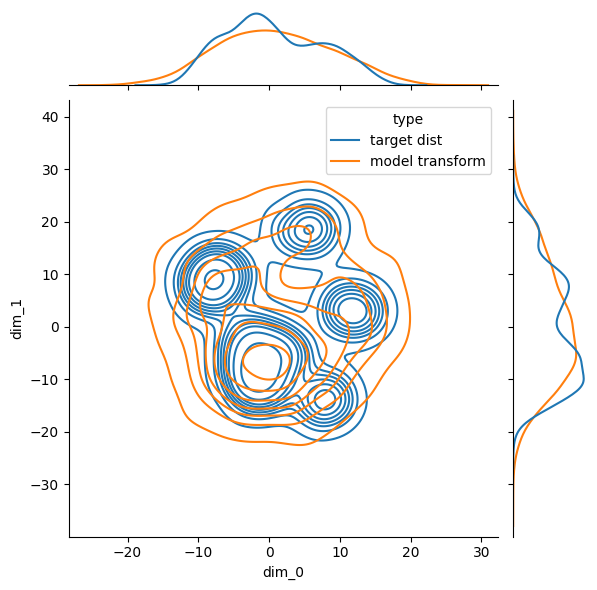

trail: 0 m step: 1 kl_test: 15.206809997558594


  2%|▏         | 100/6000 [00:31<34:40,  2.84it/s]

trail: 0 m step: 2 Loss: 12.607912063598633  L_n: 10.553010940551758  kld: 0.2054901123046875 KLD1: 10.201929092407227 KLD2: 3.6421616077423096


  3%|▎         | 200/6000 [01:03<34:12,  2.83it/s]

trail: 0 m step: 2 Loss: 12.064126968383789  L_n: 9.953645706176758  kld: 0.21104812622070312 KLD1: 10.02792739868164 KLD2: 3.5650744438171387


  5%|▌         | 300/6000 [01:35<33:34,  2.83it/s]

trail: 0 m step: 2 Loss: 12.290679931640625  L_n: 9.994327545166016  kld: 0.22963523864746094 KLD1: 9.805282592773438 KLD2: 3.515456199645996


  7%|▋         | 400/6000 [02:07<32:59,  2.83it/s]

trail: 0 m step: 2 Loss: 11.938892364501953  L_n: 9.683815002441406  kld: 0.2255077362060547 KLD1: 9.871118545532227 KLD2: 3.453641414642334


  8%|▊         | 500/6000 [02:39<32:25,  2.83it/s]

trail: 0 m step: 2 Loss: 11.939231872558594  L_n: 9.688446044921875  kld: 0.22507858276367188 KLD1: 9.775690078735352 KLD2: 3.4174718856811523


 10%|█         | 600/6000 [03:11<31:46,  2.83it/s]

trail: 0 m step: 2 Loss: 11.984516143798828  L_n: 9.610458374023438  kld: 0.23740577697753906 KLD1: 9.578516006469727 KLD2: 3.4070701599121094


 12%|█▏        | 700/6000 [03:43<31:17,  2.82it/s]

trail: 0 m step: 2 Loss: 12.000268936157227  L_n: 9.570459365844727  kld: 0.24298095703125 KLD1: 9.541696548461914 KLD2: 3.4047749042510986


 13%|█▎        | 800/6000 [04:15<30:45,  2.82it/s]

trail: 0 m step: 2 Loss: 11.742252349853516  L_n: 9.417957305908203  kld: 0.23242950439453125 KLD1: 9.57596492767334 KLD2: 3.3863909244537354


 15%|█▌        | 900/6000 [04:47<30:09,  2.82it/s]

trail: 0 m step: 2 Loss: 11.819038391113281  L_n: 9.427127838134766  kld: 0.23919105529785156 KLD1: 9.50490951538086 KLD2: 3.36446475982666


 17%|█▋        | 1000/6000 [05:19<29:28,  2.83it/s]

trail: 0 m step: 2 Loss: 11.79781723022461  L_n: 9.424636840820312  kld: 0.2373180389404297 KLD1: 9.43637752532959 KLD2: 3.378913164138794


 18%|█▊        | 1100/6000 [05:51<28:59,  2.82it/s]

trail: 0 m step: 2 Loss: 11.944046020507812  L_n: 9.460372924804688  kld: 0.2483673095703125 KLD1: 9.302868843078613 KLD2: 3.33815336227417


 20%|██        | 1200/6000 [06:23<28:21,  2.82it/s]

trail: 0 m step: 2 Loss: 11.77001953125  L_n: 9.252586364746094  kld: 0.2517433166503906 KLD1: 9.239696502685547 KLD2: 3.3328170776367188


 22%|██▏       | 1300/6000 [06:55<27:43,  2.83it/s]

trail: 0 m step: 2 Loss: 11.661216735839844  L_n: 9.117443084716797  kld: 0.2543773651123047 KLD1: 9.289661407470703 KLD2: 3.3272249698638916


 23%|██▎       | 1400/6000 [07:27<27:17,  2.81it/s]

trail: 0 m step: 2 Loss: 11.872838973999023  L_n: 9.266447067260742  kld: 0.2606391906738281 KLD1: 9.123184204101562 KLD2: 3.3252968788146973


 25%|██▌       | 1500/6000 [08:00<26:30,  2.83it/s]

trail: 0 m step: 2 Loss: 11.639078140258789  L_n: 9.135988235473633  kld: 0.2503089904785156 KLD1: 9.227584838867188 KLD2: 3.355074167251587


 27%|██▋       | 1600/6000 [08:32<25:58,  2.82it/s]

trail: 0 m step: 2 Loss: 11.83200454711914  L_n: 9.324337005615234  kld: 0.2507667541503906 KLD1: 9.263951301574707 KLD2: 3.321117877960205


 28%|██▊       | 1700/6000 [09:04<25:24,  2.82it/s]

trail: 0 m step: 2 Loss: 11.648088455200195  L_n: 9.161706924438477  kld: 0.24863815307617188 KLD1: 9.221166610717773 KLD2: 3.317129611968994


 30%|███       | 1800/6000 [09:36<24:45,  2.83it/s]

trail: 0 m step: 2 Loss: 11.713859558105469  L_n: 9.20510482788086  kld: 0.25087547302246094 KLD1: 9.110533714294434 KLD2: 3.3344225883483887


 32%|███▏      | 1900/6000 [10:08<24:13,  2.82it/s]

trail: 0 m step: 2 Loss: 11.749898910522461  L_n: 9.18083381652832  kld: 0.25690650939941406 KLD1: 9.114060401916504 KLD2: 3.3824045658111572


 33%|███▎      | 2000/6000 [10:40<23:37,  2.82it/s]

trail: 0 m step: 2 Loss: 11.755090713500977  L_n: 9.195695877075195  kld: 0.2559394836425781 KLD1: 9.110369682312012 KLD2: 3.319467544555664


 35%|███▌      | 2100/6000 [11:12<23:02,  2.82it/s]

trail: 0 m step: 2 Loss: 11.613998413085938  L_n: 9.115562438964844  kld: 0.24984359741210938 KLD1: 9.167930603027344 KLD2: 3.3062613010406494


 37%|███▋      | 2200/6000 [11:44<22:21,  2.83it/s]

trail: 0 m step: 2 Loss: 11.600147247314453  L_n: 9.032264709472656  kld: 0.2567882537841797 KLD1: 9.171248435974121 KLD2: 3.296316385269165


 38%|███▊      | 2300/6000 [12:16<21:47,  2.83it/s]

trail: 0 m step: 2 Loss: 11.649089813232422  L_n: 9.04403305053711  kld: 0.26050567626953125 KLD1: 9.022994995117188 KLD2: 3.314661741256714


 40%|████      | 2400/6000 [12:48<21:16,  2.82it/s]

trail: 0 m step: 2 Loss: 11.634613037109375  L_n: 9.066082000732422  kld: 0.2568531036376953 KLD1: 9.097156524658203 KLD2: 3.301825761795044


 42%|████▏     | 2500/6000 [13:20<20:38,  2.83it/s]

trail: 0 m step: 2 Loss: 11.75001335144043  L_n: 9.121915817260742  kld: 0.26280975341796875 KLD1: 9.021540641784668 KLD2: 3.313632011413574


 43%|████▎     | 2600/6000 [13:52<20:04,  2.82it/s]

trail: 0 m step: 2 Loss: 11.768795013427734  L_n: 9.13241958618164  kld: 0.2636375427246094 KLD1: 9.024489402770996 KLD2: 3.3427281379699707


 45%|████▌     | 2700/6000 [14:24<19:26,  2.83it/s]

trail: 0 m step: 2 Loss: 11.788944244384766  L_n: 9.077629089355469  kld: 0.2711315155029297 KLD1: 8.932746887207031 KLD2: 3.294633626937866


 47%|████▋     | 2800/6000 [14:56<18:47,  2.84it/s]

trail: 0 m step: 2 Loss: 11.59906005859375  L_n: 9.118820190429688  kld: 0.24802398681640625 KLD1: 9.127408027648926 KLD2: 3.3157365322113037


 48%|████▊     | 2900/6000 [15:28<18:15,  2.83it/s]

trail: 0 m step: 2 Loss: 11.724090576171875  L_n: 8.958187103271484  kld: 0.27659034729003906 KLD1: 8.87673568725586 KLD2: 3.3117311000823975


 50%|█████     | 3000/6000 [16:00<17:40,  2.83it/s]

trail: 0 m step: 2 Loss: 11.636032104492188  L_n: 8.9835205078125  kld: 0.26525115966796875 KLD1: 9.022921562194824 KLD2: 3.292492151260376


 52%|█████▏    | 3100/6000 [16:32<17:06,  2.82it/s]

trail: 0 m step: 2 Loss: 11.493677139282227  L_n: 9.057229995727539  kld: 0.24364471435546875 KLD1: 9.218957901000977 KLD2: 3.303173303604126


 53%|█████▎    | 3200/6000 [17:04<16:32,  2.82it/s]

trail: 0 m step: 2 Loss: 11.634014129638672  L_n: 8.986709594726562  kld: 0.26473045349121094 KLD1: 8.94674015045166 KLD2: 3.308553457260132


 55%|█████▌    | 3300/6000 [17:36<15:56,  2.82it/s]

trail: 0 m step: 2 Loss: 11.617900848388672  L_n: 9.089958190917969  kld: 0.2527942657470703 KLD1: 9.084425926208496 KLD2: 3.309793710708618


 57%|█████▋    | 3400/6000 [18:08<15:22,  2.82it/s]

trail: 0 m step: 2 Loss: 11.657958984375  L_n: 9.196983337402344  kld: 0.24609756469726562 KLD1: 9.214985847473145 KLD2: 3.3069636821746826


 58%|█████▊    | 3500/6000 [18:40<14:46,  2.82it/s]

trail: 0 m step: 2 Loss: 11.5977783203125  L_n: 9.050495147705078  kld: 0.2547283172607422 KLD1: 9.092799186706543 KLD2: 3.3054709434509277


 60%|██████    | 3600/6000 [19:12<14:10,  2.82it/s]

trail: 0 m step: 2 Loss: 11.727924346923828  L_n: 9.034671783447266  kld: 0.26932525634765625 KLD1: 8.978031158447266 KLD2: 3.3092241287231445


 62%|██████▏   | 3700/6000 [19:44<13:34,  2.83it/s]

trail: 0 m step: 2 Loss: 11.642892837524414  L_n: 9.018342971801758  kld: 0.2624549865722656 KLD1: 8.978503227233887 KLD2: 3.2954249382019043


 63%|██████▎   | 3800/6000 [20:16<13:00,  2.82it/s]

trail: 0 m step: 2 Loss: 11.623409271240234  L_n: 9.013565063476562  kld: 0.2609844207763672 KLD1: 8.97713851928711 KLD2: 3.3222429752349854


 65%|██████▌   | 3900/6000 [20:48<12:23,  2.82it/s]

trail: 0 m step: 2 Loss: 11.751184463500977  L_n: 9.098062515258789  kld: 0.26531219482421875 KLD1: 8.98493766784668 KLD2: 3.3113772869110107


 67%|██████▋   | 4000/6000 [21:20<11:47,  2.83it/s]

trail: 0 m step: 2 Loss: 11.604555130004883  L_n: 9.002225875854492  kld: 0.26023292541503906 KLD1: 9.019147872924805 KLD2: 3.2908241748809814


 68%|██████▊   | 4100/6000 [21:52<11:12,  2.83it/s]

trail: 0 m step: 2 Loss: 11.446544647216797  L_n: 8.944637298583984  kld: 0.25019073486328125 KLD1: 9.142759323120117 KLD2: 3.3038806915283203


 70%|███████   | 4200/6000 [22:24<10:37,  2.82it/s]

trail: 0 m step: 2 Loss: 11.433492660522461  L_n: 8.842702865600586  kld: 0.2590789794921875 KLD1: 8.983659744262695 KLD2: 3.312899112701416


 72%|███████▏  | 4300/6000 [22:56<10:02,  2.82it/s]

trail: 0 m step: 2 Loss: 11.681451797485352  L_n: 9.014997482299805  kld: 0.2666454315185547 KLD1: 8.906963348388672 KLD2: 3.288323402404785


 73%|███████▎  | 4400/6000 [23:28<09:26,  2.83it/s]

trail: 0 m step: 2 Loss: 11.607328414916992  L_n: 9.038129806518555  kld: 0.25691986083984375 KLD1: 9.022558212280273 KLD2: 3.2748029232025146


 75%|███████▌  | 4500/6000 [24:00<08:51,  2.82it/s]

trail: 0 m step: 2 Loss: 11.665191650390625  L_n: 9.074153900146484  kld: 0.25910377502441406 KLD1: 9.00399112701416 KLD2: 3.300356864929199


 77%|███████▋  | 4600/6000 [24:32<08:16,  2.82it/s]

trail: 0 m step: 2 Loss: 11.465856552124023  L_n: 8.872282028198242  kld: 0.2593574523925781 KLD1: 9.011262893676758 KLD2: 3.2918756008148193


 78%|███████▊  | 4700/6000 [25:04<07:40,  2.82it/s]

trail: 0 m step: 2 Loss: 11.611213684082031  L_n: 8.90777587890625  kld: 0.2703437805175781 KLD1: 8.8639554977417 KLD2: 3.2970428466796875


 80%|████████  | 4800/6000 [25:36<07:03,  2.83it/s]

trail: 0 m step: 2 Loss: 11.37150764465332  L_n: 8.897943496704102  kld: 0.24735641479492188 KLD1: 9.10269832611084 KLD2: 3.27829647064209


 82%|████████▏ | 4900/6000 [26:08<06:30,  2.82it/s]

trail: 0 m step: 2 Loss: 11.559497833251953  L_n: 9.01253890991211  kld: 0.2546958923339844 KLD1: 9.06042194366455 KLD2: 3.26798939704895


 83%|████████▎ | 5000/6000 [26:40<05:54,  2.82it/s]

trail: 0 m step: 2 Loss: 11.611442565917969  L_n: 8.985328674316406  kld: 0.26261138916015625 KLD1: 8.931093215942383 KLD2: 3.271660566329956


 85%|████████▌ | 5100/6000 [27:12<05:18,  2.83it/s]

trail: 0 m step: 2 Loss: 11.642791748046875  L_n: 8.949043273925781  kld: 0.2693748474121094 KLD1: 8.844034194946289 KLD2: 3.3036718368530273


 87%|████████▋ | 5200/6000 [27:44<04:43,  2.83it/s]

trail: 0 m step: 2 Loss: 11.55512809753418  L_n: 8.927755355834961  kld: 0.2627372741699219 KLD1: 8.98112964630127 KLD2: 3.2665109634399414


 88%|████████▊ | 5300/6000 [28:16<04:07,  2.83it/s]

trail: 0 m step: 2 Loss: 11.643823623657227  L_n: 8.961786270141602  kld: 0.2682037353515625 KLD1: 8.86807918548584 KLD2: 3.2686753273010254


 90%|█████████ | 5400/6000 [28:48<03:33,  2.82it/s]

trail: 0 m step: 2 Loss: 11.616077423095703  L_n: 8.969249725341797  kld: 0.2646827697753906 KLD1: 8.909024238586426 KLD2: 3.3027701377868652


 92%|█████████▏| 5500/6000 [29:20<02:57,  2.82it/s]

trail: 0 m step: 2 Loss: 11.536676406860352  L_n: 8.895818710327148  kld: 0.2640857696533203 KLD1: 8.938945770263672 KLD2: 3.254034996032715


 93%|█████████▎| 5600/6000 [29:52<02:21,  2.83it/s]

trail: 0 m step: 2 Loss: 11.705301284790039  L_n: 8.950288772583008  kld: 0.2755012512207031 KLD1: 8.796098709106445 KLD2: 3.268756151199341


 95%|█████████▌| 5700/6000 [30:24<01:46,  2.82it/s]

trail: 0 m step: 2 Loss: 11.485511779785156  L_n: 8.821136474609375  kld: 0.2664375305175781 KLD1: 8.843487739562988 KLD2: 3.283907651901245


 97%|█████████▋| 5800/6000 [30:56<01:10,  2.82it/s]

trail: 0 m step: 2 Loss: 11.639739990234375  L_n: 8.91375732421875  kld: 0.2725982666015625 KLD1: 8.861920356750488 KLD2: 3.2579233646392822


 98%|█████████▊| 5900/6000 [31:28<00:35,  2.82it/s]

trail: 0 m step: 2 Loss: 11.77324104309082  L_n: 8.953550338745117  kld: 0.2819690704345703 KLD1: 8.723681449890137 KLD2: 3.280461549758911


100%|██████████| 6000/6000 [32:00<00:00,  3.12it/s]

trail: 0 m step: 2 Loss: 11.551897048950195  L_n: 8.889314651489258  kld: 0.26625823974609375 KLD1: 8.916571617126465 KLD2: 3.268965244293213



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


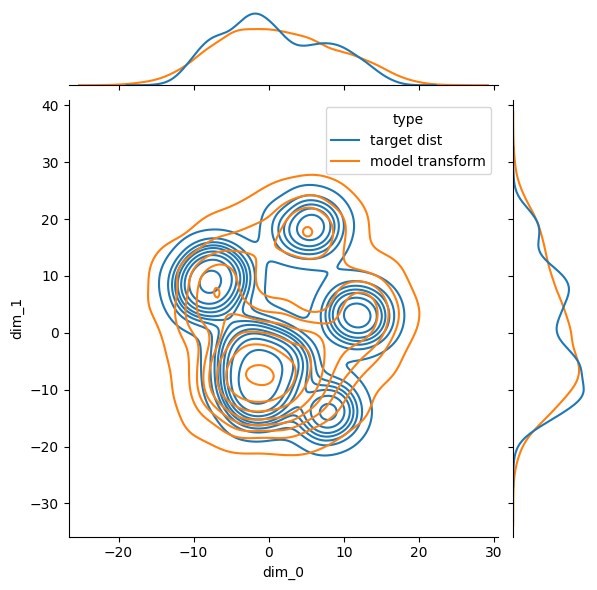

trail: 0 m step: 2 kl_test: 8.84958267211914


  2%|▏         | 100/6000 [00:31<34:45,  2.83it/s]

trail: 0 m step: 3 Loss: 7.562458038330078  L_n: 6.435558319091797  kld: 0.11268997192382812 KLD1: 6.279132843017578 KLD2: 2.589622974395752


  3%|▎         | 200/6000 [01:03<34:09,  2.83it/s]

trail: 0 m step: 3 Loss: 7.24098014831543  L_n: 6.130216598510742  kld: 0.11107635498046875 KLD1: 6.197696208953857 KLD2: 2.5577893257141113


  5%|▌         | 300/6000 [01:35<33:37,  2.82it/s]

trail: 0 m step: 3 Loss: 7.447057723999023  L_n: 6.172147750854492  kld: 0.12749099731445312 KLD1: 6.030712127685547 KLD2: 2.5294644832611084


  7%|▋         | 400/6000 [02:07<33:04,  2.82it/s]

trail: 0 m step: 3 Loss: 7.16314697265625  L_n: 5.981239318847656  kld: 0.11819076538085938 KLD1: 6.179893493652344 KLD2: 2.5084986686706543


  8%|▊         | 500/6000 [02:39<32:20,  2.83it/s]

trail: 0 m step: 3 Loss: 7.226461410522461  L_n: 6.049055099487305  kld: 0.11774063110351562 KLD1: 6.114089488983154 KLD2: 2.4868597984313965


 10%|█         | 600/6000 [03:11<31:51,  2.82it/s]

trail: 0 m step: 3 Loss: 7.27421760559082  L_n: 6.040220260620117  kld: 0.12339973449707031 KLD1: 6.022893905639648 KLD2: 2.4819462299346924


 12%|█▏        | 700/6000 [03:43<31:18,  2.82it/s]

trail: 0 m step: 3 Loss: 7.297964096069336  L_n: 6.022729873657227  kld: 0.12752342224121094 KLD1: 6.00098991394043 KLD2: 2.4901273250579834


 13%|█▎        | 800/6000 [04:15<30:39,  2.83it/s]

trail: 0 m step: 3 Loss: 7.1249542236328125  L_n: 5.917564392089844  kld: 0.12073898315429688 KLD1: 6.005565166473389 KLD2: 2.4720609188079834


 15%|█▌        | 900/6000 [04:47<30:06,  2.82it/s]

trail: 0 m step: 3 Loss: 7.160511016845703  L_n: 5.89874267578125  kld: 0.1261768341064453 KLD1: 5.984643459320068 KLD2: 2.455885887145996


 17%|█▋        | 1000/6000 [05:19<29:38,  2.81it/s]

trail: 0 m step: 3 Loss: 7.143148422241211  L_n: 5.904783248901367  kld: 0.12383651733398438 KLD1: 5.931636333465576 KLD2: 2.472338914871216


 18%|█▊        | 1100/6000 [05:52<29:06,  2.81it/s]

trail: 0 m step: 3 Loss: 7.270261764526367  L_n: 5.957300186157227  kld: 0.13129615783691406 KLD1: 5.864674091339111 KLD2: 2.436328649520874


 20%|██        | 1200/6000 [06:24<29:53,  2.68it/s]

trail: 0 m step: 3 Loss: 7.170495986938477  L_n: 5.836782455444336  kld: 0.13337135314941406 KLD1: 5.814197540283203 KLD2: 2.4356184005737305


 22%|██▏       | 1300/6000 [06:56<27:57,  2.80it/s]

trail: 0 m step: 3 Loss: 7.11798095703125  L_n: 5.764678955078125  kld: 0.1353302001953125 KLD1: 5.8350677490234375 KLD2: 2.4393365383148193


 23%|██▎       | 1400/6000 [07:28<27:08,  2.82it/s]

trail: 0 m step: 3 Loss: 7.279766082763672  L_n: 5.883892059326172  kld: 0.13958740234375 KLD1: 5.748207092285156 KLD2: 2.4374568462371826


 25%|██▌       | 1500/6000 [08:00<26:32,  2.83it/s]

trail: 0 m step: 3 Loss: 7.058488845825195  L_n: 5.755350112915039  kld: 0.13031387329101562 KLD1: 5.871240615844727 KLD2: 2.463024854660034


 27%|██▋       | 1600/6000 [08:32<25:58,  2.82it/s]

trail: 0 m step: 3 Loss: 7.173620223999023  L_n: 5.880571365356445  kld: 0.1293048858642578 KLD1: 5.828365802764893 KLD2: 2.4509572982788086


 28%|██▊       | 1700/6000 [09:04<25:28,  2.81it/s]

trail: 0 m step: 3 Loss: 7.148735046386719  L_n: 5.848686218261719  kld: 0.1300048828125 KLD1: 5.827447414398193 KLD2: 2.42773699760437


 30%|███       | 1800/6000 [09:36<24:44,  2.83it/s]

trail: 0 m step: 3 Loss: 7.133600234985352  L_n: 5.798437118530273  kld: 0.1335163116455078 KLD1: 5.7774858474731445 KLD2: 2.4481711387634277


 32%|███▏      | 1900/6000 [10:08<24:15,  2.82it/s]

trail: 0 m step: 3 Loss: 7.201389312744141  L_n: 5.837596893310547  kld: 0.13637924194335938 KLD1: 5.805001258850098 KLD2: 2.494905710220337


 33%|███▎      | 2000/6000 [10:40<23:39,  2.82it/s]

trail: 0 m step: 3 Loss: 7.166736602783203  L_n: 5.838993072509766  kld: 0.13277435302734375 KLD1: 5.748067855834961 KLD2: 2.434906244277954


 35%|███▌      | 2100/6000 [11:12<23:05,  2.81it/s]

trail: 0 m step: 3 Loss: 7.090373992919922  L_n: 5.799842834472656  kld: 0.12905311584472656 KLD1: 5.815006256103516 KLD2: 2.4268460273742676


 37%|███▋      | 2200/6000 [11:44<22:24,  2.83it/s]

trail: 0 m step: 3 Loss: 7.063167572021484  L_n: 5.752323150634766  kld: 0.13108444213867188 KLD1: 5.807993412017822 KLD2: 2.419809341430664


 38%|███▊      | 2300/6000 [12:16<21:51,  2.82it/s]

trail: 0 m step: 3 Loss: 7.110857009887695  L_n: 5.748971939086914  kld: 0.13618850708007812 KLD1: 5.748869895935059 KLD2: 2.441685199737549


 40%|████      | 2400/6000 [12:48<21:12,  2.83it/s]

trail: 0 m step: 3 Loss: 7.085521697998047  L_n: 5.726879119873047  kld: 0.1358642578125 KLD1: 5.723085880279541 KLD2: 2.4232687950134277


 42%|████▏     | 2500/6000 [13:20<20:41,  2.82it/s]

trail: 0 m step: 3 Loss: 7.14082145690918  L_n: 5.760377883911133  kld: 0.1380443572998047 KLD1: 5.676628112792969 KLD2: 2.4371235370635986


 43%|████▎     | 2600/6000 [13:53<20:08,  2.81it/s]

trail: 0 m step: 3 Loss: 7.15626335144043  L_n: 5.777250289916992  kld: 0.13790130615234375 KLD1: 5.716477394104004 KLD2: 2.4632318019866943


 45%|████▌     | 2700/6000 [14:25<19:31,  2.82it/s]

trail: 0 m step: 3 Loss: 7.194004058837891  L_n: 5.734920501708984  kld: 0.14590835571289062 KLD1: 5.672059059143066 KLD2: 2.4185116291046143


 47%|████▋     | 2800/6000 [14:57<18:59,  2.81it/s]

trail: 0 m step: 3 Loss: 7.055198669433594  L_n: 5.813018798828125  kld: 0.12421798706054688 KLD1: 5.841814994812012 KLD2: 2.4446871280670166


 48%|████▊     | 2900/6000 [15:29<18:15,  2.83it/s]

trail: 0 m step: 3 Loss: 7.1755828857421875  L_n: 5.709423065185547  kld: 0.14661598205566406 KLD1: 5.6577606201171875 KLD2: 2.4421701431274414


 50%|█████     | 3000/6000 [16:01<17:42,  2.82it/s]

trail: 0 m step: 3 Loss: 7.068387985229492  L_n: 5.712759017944336  kld: 0.13556289672851562 KLD1: 5.711345672607422 KLD2: 2.4258363246917725


 52%|█████▏    | 3100/6000 [16:33<17:11,  2.81it/s]

trail: 0 m step: 3 Loss: 7.007303237915039  L_n: 5.762643814086914  kld: 0.1244659423828125 KLD1: 5.853100776672363 KLD2: 2.431356191635132


 53%|█████▎    | 3200/6000 [17:05<16:37,  2.81it/s]

trail: 0 m step: 3 Loss: 7.072431564331055  L_n: 5.67030143737793  kld: 0.1402130126953125 KLD1: 5.673897743225098 KLD2: 2.4349052906036377


 55%|█████▌    | 3300/6000 [17:37<15:54,  2.83it/s]

trail: 0 m step: 3 Loss: 7.143547058105469  L_n: 5.80889892578125  kld: 0.13346481323242188 KLD1: 5.758171558380127 KLD2: 2.436967134475708


 57%|█████▋    | 3400/6000 [18:09<15:20,  2.82it/s]

trail: 0 m step: 3 Loss: 7.141378402709961  L_n: 5.881937026977539  kld: 0.1259441375732422 KLD1: 5.867516040802002 KLD2: 2.43764328956604


 58%|█████▊    | 3500/6000 [18:41<14:44,  2.83it/s]

trail: 0 m step: 3 Loss: 7.062232971191406  L_n: 5.767829895019531  kld: 0.1294403076171875 KLD1: 5.831069469451904 KLD2: 2.4388439655303955


 60%|██████    | 3600/6000 [19:13<14:09,  2.83it/s]

trail: 0 m step: 3 Loss: 7.126369476318359  L_n: 5.707149505615234  kld: 0.1419219970703125 KLD1: 5.707235813140869 KLD2: 2.438509225845337


 62%|██████▏   | 3700/6000 [19:45<13:31,  2.83it/s]

trail: 0 m step: 3 Loss: 7.1175079345703125  L_n: 5.745571136474609  kld: 0.1371936798095703 KLD1: 5.728074073791504 KLD2: 2.4238171577453613


 63%|██████▎   | 3800/6000 [20:17<12:59,  2.82it/s]

trail: 0 m step: 3 Loss: 7.104574203491211  L_n: 5.729948043823242  kld: 0.13746261596679688 KLD1: 5.744152069091797 KLD2: 2.4502718448638916


 65%|██████▌   | 3900/6000 [20:49<12:23,  2.82it/s]

trail: 0 m step: 3 Loss: 7.122745513916016  L_n: 5.715217590332031  kld: 0.14075279235839844 KLD1: 5.689393520355225 KLD2: 2.4394285678863525


 67%|██████▋   | 4000/6000 [21:21<11:48,  2.82it/s]

trail: 0 m step: 3 Loss: 7.04234504699707  L_n: 5.707944869995117  kld: 0.1334400177001953 KLD1: 5.771426677703857 KLD2: 2.4238343238830566


 68%|██████▊   | 4100/6000 [21:53<11:13,  2.82it/s]

trail: 0 m step: 3 Loss: 6.920591354370117  L_n: 5.664449691772461  kld: 0.12561416625976562 KLD1: 5.866397857666016 KLD2: 2.4336912631988525


 70%|███████   | 4200/6000 [22:25<10:36,  2.83it/s]

trail: 0 m step: 3 Loss: 6.933506011962891  L_n: 5.585334777832031  kld: 0.13481712341308594 KLD1: 5.697171211242676 KLD2: 2.444382429122925


 72%|███████▏  | 4300/6000 [22:57<10:01,  2.83it/s]

trail: 0 m step: 3 Loss: 7.116292953491211  L_n: 5.705522537231445  kld: 0.14107704162597656 KLD1: 5.617985725402832 KLD2: 2.421264171600342


 73%|███████▎  | 4400/6000 [23:29<09:28,  2.81it/s]

trail: 0 m step: 3 Loss: 7.075611114501953  L_n: 5.732456207275391  kld: 0.13431549072265625 KLD1: 5.699671745300293 KLD2: 2.4113426208496094


 75%|███████▌  | 4500/6000 [24:01<08:51,  2.82it/s]

trail: 0 m step: 3 Loss: 7.140539169311523  L_n: 5.78559684753418  kld: 0.13549423217773438 KLD1: 5.747487545013428 KLD2: 2.4333460330963135


 77%|███████▋  | 4600/6000 [24:33<08:17,  2.81it/s]

trail: 0 m step: 3 Loss: 7.011178970336914  L_n: 5.669588088989258  kld: 0.13415908813476562 KLD1: 5.741273403167725 KLD2: 2.4287681579589844


 78%|███████▊  | 4700/6000 [25:05<07:40,  2.82it/s]

trail: 0 m step: 3 Loss: 7.114011764526367  L_n: 5.68992805480957  kld: 0.1424083709716797 KLD1: 5.632906913757324 KLD2: 2.4295220375061035


 80%|████████  | 4800/6000 [25:37<07:05,  2.82it/s]

trail: 0 m step: 3 Loss: 6.922834396362305  L_n: 5.629861831665039  kld: 0.12929725646972656 KLD1: 5.7939629554748535 KLD2: 2.408759832382202


 82%|████████▏ | 4900/6000 [26:09<06:29,  2.82it/s]

trail: 0 m step: 3 Loss: 7.066967010498047  L_n: 5.748340606689453  kld: 0.13186264038085938 KLD1: 5.745309352874756 KLD2: 2.402193307876587


 83%|████████▎ | 5000/6000 [26:41<05:54,  2.82it/s]

trail: 0 m step: 3 Loss: 7.043447494506836  L_n: 5.692453384399414  kld: 0.1350994110107422 KLD1: 5.680290222167969 KLD2: 2.40861177444458


 85%|████████▌ | 5100/6000 [27:13<05:18,  2.83it/s]

trail: 0 m step: 3 Loss: 7.11924934387207  L_n: 5.69438362121582  kld: 0.142486572265625 KLD1: 5.572558879852295 KLD2: 2.4386403560638428


 87%|████████▋ | 5200/6000 [27:45<04:42,  2.83it/s]

trail: 0 m step: 3 Loss: 7.016862869262695  L_n: 5.640233993530273  kld: 0.1376628875732422 KLD1: 5.7008843421936035 KLD2: 2.4086930751800537


 88%|████████▊ | 5300/6000 [28:17<04:08,  2.82it/s]

trail: 0 m step: 3 Loss: 7.104789733886719  L_n: 5.70208740234375  kld: 0.14027023315429688 KLD1: 5.686466693878174 KLD2: 2.4052817821502686


 90%|█████████ | 5400/6000 [28:49<03:32,  2.83it/s]

trail: 0 m step: 3 Loss: 7.072572708129883  L_n: 5.677289962768555  kld: 0.1395282745361328 KLD1: 5.627057075500488 KLD2: 2.43635892868042


 92%|█████████▏| 5500/6000 [29:22<02:56,  2.83it/s]

trail: 0 m step: 3 Loss: 7.028982162475586  L_n: 5.650503158569336  kld: 0.137847900390625 KLD1: 5.665997505187988 KLD2: 2.3947932720184326


 93%|█████████▎| 5600/6000 [29:54<02:21,  2.83it/s]

trail: 0 m step: 3 Loss: 7.143033981323242  L_n: 5.690454483032227  kld: 0.14525794982910156 KLD1: 5.580423355102539 KLD2: 2.406810760498047


 95%|█████████▌| 5700/6000 [30:26<01:46,  2.83it/s]

trail: 0 m step: 3 Loss: 6.989513397216797  L_n: 5.588470458984375  kld: 0.1401042938232422 KLD1: 5.659332275390625 KLD2: 2.4225986003875732


 97%|█████████▋| 5800/6000 [30:58<01:10,  2.83it/s]

trail: 0 m step: 3 Loss: 7.056495666503906  L_n: 5.641300201416016  kld: 0.14151954650878906 KLD1: 5.650445938110352 KLD2: 2.397237777709961


 98%|█████████▊| 5900/6000 [31:30<00:35,  2.83it/s]

trail: 0 m step: 3 Loss: 7.234529495239258  L_n: 5.718568801879883  kld: 0.1515960693359375 KLD1: 5.530621528625488 KLD2: 2.4196937084198


100%|██████████| 6000/6000 [32:02<00:00,  3.12it/s]

trail: 0 m step: 3 Loss: 7.013883590698242  L_n: 5.643014907836914  kld: 0.1370868682861328 KLD1: 5.686838150024414 KLD2: 2.4073877334594727



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


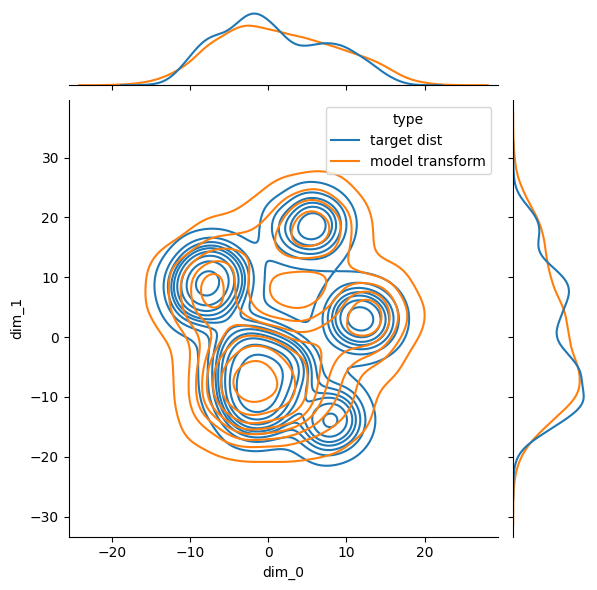

trail: 0 m step: 3 kl_test: 5.669740676879883


  2%|▏         | 100/6000 [00:32<35:07,  2.80it/s]

trail: 0 m step: 4 Loss: 4.9165802001953125  L_n: 4.235790252685547  kld: 0.06807899475097656 KLD1: 4.144044399261475 KLD2: 1.9295101165771484


  3%|▎         | 200/6000 [01:04<34:14,  2.82it/s]

trail: 0 m step: 4 Loss: 4.7222900390625  L_n: 4.061794281005859  kld: 0.06604957580566406 KLD1: 4.1622772216796875 KLD2: 1.9211512804031372


  5%|▌         | 300/6000 [01:36<33:42,  2.82it/s]

trail: 0 m step: 4 Loss: 4.887302398681641  L_n: 4.1437225341796875  kld: 0.07435798645019531 KLD1: 4.047141075134277 KLD2: 1.9101417064666748


  7%|▋         | 400/6000 [02:08<33:12,  2.81it/s]

trail: 0 m step: 4 Loss: 4.714870452880859  L_n: 4.035186767578125  kld: 0.06796836853027344 KLD1: 4.129825592041016 KLD2: 1.8881522417068481


  8%|▊         | 500/6000 [02:40<32:44,  2.80it/s]

trail: 0 m step: 4 Loss: 4.733304977416992  L_n: 4.06489372253418  kld: 0.06684112548828125 KLD1: 4.156064510345459 KLD2: 1.8824671506881714


 10%|█         | 600/6000 [03:12<32:04,  2.81it/s]

trail: 0 m step: 4 Loss: 4.7786407470703125  L_n: 4.051521301269531  kld: 0.07271194458007812 KLD1: 4.007790565490723 KLD2: 1.86373770236969


 12%|█▏        | 700/6000 [03:44<31:21,  2.82it/s]

trail: 0 m step: 4 Loss: 4.8326263427734375  L_n: 4.087120056152344  kld: 0.07455062866210938 KLD1: 3.998133420944214 KLD2: 1.8879135847091675


 13%|█▎        | 800/6000 [04:16<30:50,  2.81it/s]

trail: 0 m step: 4 Loss: 4.720602035522461  L_n: 4.015913009643555  kld: 0.07046890258789062 KLD1: 4.0406622886657715 KLD2: 1.8745479583740234


 15%|█▌        | 900/6000 [04:48<30:05,  2.82it/s]

trail: 0 m step: 4 Loss: 4.67156982421875  L_n: 3.964496612548828  kld: 0.07070732116699219 KLD1: 4.065333366394043 KLD2: 1.8582286834716797


 17%|█▋        | 1000/6000 [05:21<29:34,  2.82it/s]

trail: 0 m step: 4 Loss: 4.704734802246094  L_n: 3.988372802734375  kld: 0.07163619995117188 KLD1: 3.996311902999878 KLD2: 1.867753028869629


 18%|█▊        | 1100/6000 [05:53<28:56,  2.82it/s]

trail: 0 m step: 4 Loss: 4.775442123413086  L_n: 4.016355514526367  kld: 0.07590866088867188 KLD1: 3.9791014194488525 KLD2: 1.84286630153656


 20%|██        | 1200/6000 [06:25<28:19,  2.82it/s]

trail: 0 m step: 4 Loss: 4.708393096923828  L_n: 3.93170166015625  kld: 0.07766914367675781 KLD1: 3.953437328338623 KLD2: 1.8467737436294556


 22%|██▏       | 1300/6000 [06:57<27:50,  2.81it/s]

trail: 0 m step: 4 Loss: 4.685588836669922  L_n: 3.912883758544922  kld: 0.0772705078125 KLD1: 3.9280292987823486 KLD2: 1.8425893783569336


 23%|██▎       | 1400/6000 [07:29<27:08,  2.83it/s]

trail: 0 m step: 4 Loss: 4.82890510559082  L_n: 4.013093948364258  kld: 0.08158111572265625 KLD1: 3.880821466445923 KLD2: 1.8478206396102905


 25%|██▌       | 1500/6000 [08:01<26:28,  2.83it/s]

trail: 0 m step: 4 Loss: 4.617984771728516  L_n: 3.877704620361328  kld: 0.07402801513671875 KLD1: 3.9876725673675537 KLD2: 1.8687273263931274


 27%|██▋       | 1600/6000 [08:33<26:01,  2.82it/s]

trail: 0 m step: 4 Loss: 4.713136672973633  L_n: 3.983938217163086  kld: 0.07291984558105469 KLD1: 3.9627292156219482 KLD2: 1.8607325553894043


 28%|██▊       | 1700/6000 [09:05<25:27,  2.81it/s]

trail: 0 m step: 4 Loss: 4.722747802734375  L_n: 3.984832763671875  kld: 0.07379150390625 KLD1: 3.950869083404541 KLD2: 1.8414491415023804


 30%|███       | 1800/6000 [09:37<24:48,  2.82it/s]

trail: 0 m step: 4 Loss: 4.70402717590332  L_n: 3.9038562774658203  kld: 0.08001708984375 KLD1: 3.8733842372894287 KLD2: 1.8576749563217163


 32%|███▏      | 1900/6000 [10:09<24:14,  2.82it/s]

trail: 0 m step: 4 Loss: 4.731151580810547  L_n: 3.9323158264160156  kld: 0.07988357543945312 KLD1: 3.933065176010132 KLD2: 1.8979202508926392


 33%|███▎      | 2000/6000 [10:41<23:35,  2.83it/s]

trail: 0 m step: 4 Loss: 4.721559524536133  L_n: 3.9385929107666016  kld: 0.07829666137695312 KLD1: 3.910905361175537 KLD2: 1.8413267135620117


 35%|███▌      | 2100/6000 [11:13<23:02,  2.82it/s]

trail: 0 m step: 4 Loss: 4.644338607788086  L_n: 3.911458969116211  kld: 0.0732879638671875 KLD1: 3.914184331893921 KLD2: 1.840604305267334


 37%|███▋      | 2200/6000 [11:45<22:25,  2.82it/s]

trail: 0 m step: 4 Loss: 4.643564224243164  L_n: 3.9021968841552734  kld: 0.07413673400878906 KLD1: 3.943204641342163 KLD2: 1.83510422706604


 38%|███▊      | 2300/6000 [12:17<21:54,  2.82it/s]

trail: 0 m step: 4 Loss: 4.654077529907227  L_n: 3.8776912689208984  kld: 0.07763862609863281 KLD1: 3.905675172805786 KLD2: 1.8549741506576538


 40%|████      | 2400/6000 [12:49<21:16,  2.82it/s]

trail: 0 m step: 4 Loss: 4.6585540771484375  L_n: 3.8800506591796875  kld: 0.077850341796875 KLD1: 3.871459722518921 KLD2: 1.8341907262802124


 42%|████▏     | 2500/6000 [13:21<20:38,  2.82it/s]

trail: 0 m step: 4 Loss: 4.71820068359375  L_n: 3.915740966796875  kld: 0.0802459716796875 KLD1: 3.8695151805877686 KLD2: 1.84434175491333


 43%|████▎     | 2600/6000 [13:53<20:06,  2.82it/s]

trail: 0 m step: 4 Loss: 4.687030792236328  L_n: 3.886974334716797  kld: 0.08000564575195312 KLD1: 3.871962308883667 KLD2: 1.8735042810440063


 45%|████▌     | 2700/6000 [14:25<19:25,  2.83it/s]

trail: 0 m step: 4 Loss: 4.724723815917969  L_n: 3.8633651733398438  kld: 0.0861358642578125 KLD1: 3.801179885864258 KLD2: 1.8355200290679932


 47%|████▋     | 2800/6000 [14:57<18:49,  2.83it/s]

trail: 0 m step: 4 Loss: 4.59326171875  L_n: 3.9097442626953125  kld: 0.06835174560546875 KLD1: 3.973341226577759 KLD2: 1.8601937294006348


 48%|████▊     | 2900/6000 [15:29<18:19,  2.82it/s]

trail: 0 m step: 4 Loss: 4.732954025268555  L_n: 3.8723201751708984  kld: 0.08606338500976562 KLD1: 3.8203046321868896 KLD2: 1.8549087047576904


 50%|█████     | 3000/6000 [16:01<17:42,  2.82it/s]

trail: 0 m step: 4 Loss: 4.612295150756836  L_n: 3.8479442596435547  kld: 0.07643508911132812 KLD1: 3.8982670307159424 KLD2: 1.843977689743042


 52%|█████▏    | 3100/6000 [16:33<17:09,  2.82it/s]

trail: 0 m step: 4 Loss: 4.596902847290039  L_n: 3.9039249420166016  kld: 0.06929779052734375 KLD1: 4.009463787078857 KLD2: 1.847259759902954


 53%|█████▎    | 3200/6000 [17:05<16:31,  2.82it/s]

trail: 0 m step: 4 Loss: 4.636629104614258  L_n: 3.8245182037353516  kld: 0.08121109008789062 KLD1: 3.8362960815429688 KLD2: 1.847556233406067


 55%|█████▌    | 3300/6000 [17:37<15:58,  2.82it/s]

trail: 0 m step: 4 Loss: 4.683197021484375  L_n: 3.907573699951172  kld: 0.07756233215332031 KLD1: 3.863529920578003 KLD2: 1.8527108430862427


 57%|█████▋    | 3400/6000 [18:09<15:20,  2.82it/s]

trail: 0 m step: 4 Loss: 4.687690734863281  L_n: 3.9790725708007812  kld: 0.07086181640625 KLD1: 3.981149196624756 KLD2: 1.8518140316009521


 58%|█████▊    | 3500/6000 [18:41<14:48,  2.81it/s]

trail: 0 m step: 4 Loss: 4.676460266113281  L_n: 3.9503517150878906  kld: 0.07261085510253906 KLD1: 3.973076343536377 KLD2: 1.8544255495071411


 60%|██████    | 3600/6000 [19:13<14:11,  2.82it/s]

trail: 0 m step: 4 Loss: 4.702667236328125  L_n: 3.890727996826172  kld: 0.08119392395019531 KLD1: 3.8996810913085938 KLD2: 1.859556794166565


 62%|██████▏   | 3700/6000 [19:45<13:35,  2.82it/s]

trail: 0 m step: 4 Loss: 4.677478790283203  L_n: 3.885089874267578  kld: 0.0792388916015625 KLD1: 3.856520175933838 KLD2: 1.847796082496643


 63%|██████▎   | 3800/6000 [20:17<13:03,  2.81it/s]

trail: 0 m step: 4 Loss: 4.672637939453125  L_n: 3.90313720703125  kld: 0.0769500732421875 KLD1: 3.927968978881836 KLD2: 1.8667696714401245


 65%|██████▌   | 3900/6000 [20:49<12:23,  2.82it/s]

trail: 0 m step: 4 Loss: 4.7246856689453125  L_n: 3.8846511840820312  kld: 0.08400344848632812 KLD1: 3.8234643936157227 KLD2: 1.8518999814987183


 67%|██████▋   | 4000/6000 [21:21<11:50,  2.81it/s]

trail: 0 m step: 4 Loss: 4.635320663452148  L_n: 3.8728389739990234  kld: 0.0762481689453125 KLD1: 3.914698362350464 KLD2: 1.8367390632629395


 68%|██████▊   | 4100/6000 [21:53<11:12,  2.83it/s]

trail: 0 m step: 4 Loss: 4.507297515869141  L_n: 3.821605682373047  kld: 0.06856918334960938 KLD1: 3.996161699295044 KLD2: 1.8506827354431152


 70%|███████   | 4200/6000 [22:25<10:37,  2.82it/s]

trail: 0 m step: 4 Loss: 4.549825668334961  L_n: 3.782804489135742  kld: 0.07670211791992188 KLD1: 3.8397204875946045 KLD2: 1.8625061511993408


 72%|███████▏  | 4300/6000 [22:58<10:03,  2.81it/s]

trail: 0 m step: 4 Loss: 4.678813934326172  L_n: 3.8627357482910156  kld: 0.08160781860351562 KLD1: 3.827821731567383 KLD2: 1.8377933502197266


 73%|███████▎  | 4400/6000 [23:30<09:29,  2.81it/s]

trail: 0 m step: 4 Loss: 4.64909553527832  L_n: 3.8823413848876953  kld: 0.0766754150390625 KLD1: 3.854538917541504 KLD2: 1.8327059745788574


 75%|███████▌  | 4500/6000 [24:02<08:50,  2.83it/s]

trail: 0 m step: 4 Loss: 4.681978225708008  L_n: 3.9236927032470703  kld: 0.07582855224609375 KLD1: 3.8940632343292236 KLD2: 1.8503835201263428


 77%|███████▋  | 4600/6000 [24:34<08:16,  2.82it/s]

trail: 0 m step: 4 Loss: 4.604682922363281  L_n: 3.8330650329589844  kld: 0.07716178894042969 KLD1: 3.8792648315429688 KLD2: 1.8463913202285767


 78%|███████▊  | 4700/6000 [25:06<07:41,  2.82it/s]

trail: 0 m step: 4 Loss: 4.698509216308594  L_n: 3.869251251220703  kld: 0.08292579650878906 KLD1: 3.820068359375 KLD2: 1.8500604629516602


 80%|████████  | 4800/6000 [25:38<07:05,  2.82it/s]

trail: 0 m step: 4 Loss: 4.542097091674805  L_n: 3.8140621185302734  kld: 0.07280349731445312 KLD1: 3.922463893890381 KLD2: 1.8280110359191895


 82%|████████▏ | 4900/6000 [26:10<06:29,  2.82it/s]

trail: 0 m step: 4 Loss: 4.648820877075195  L_n: 3.890573501586914  kld: 0.07582473754882812 KLD1: 3.8885576725006104 KLD2: 1.8212890625


 83%|████████▎ | 5000/6000 [26:42<05:54,  2.82it/s]

trail: 0 m step: 4 Loss: 4.606513977050781  L_n: 3.8425636291503906  kld: 0.07639503479003906 KLD1: 3.8686041831970215 KLD2: 1.8281666040420532


 85%|████████▌ | 5100/6000 [27:14<05:19,  2.82it/s]

trail: 0 m step: 4 Loss: 4.695186614990234  L_n: 3.8590621948242188  kld: 0.08361244201660156 KLD1: 3.7753171920776367 KLD2: 1.855848789215088


 87%|████████▋ | 5200/6000 [27:46<04:43,  2.82it/s]

trail: 0 m step: 4 Loss: 4.59246826171875  L_n: 3.8101119995117188  kld: 0.07823562622070312 KLD1: 3.892772912979126 KLD2: 1.8313053846359253


 88%|████████▊ | 5300/6000 [28:18<04:08,  2.82it/s]

trail: 0 m step: 4 Loss: 4.668855667114258  L_n: 3.875608444213867  kld: 0.07932472229003906 KLD1: 3.878777265548706 KLD2: 1.8246870040893555


 90%|█████████ | 5400/6000 [28:50<03:34,  2.80it/s]

trail: 0 m step: 4 Loss: 4.655513763427734  L_n: 3.8492584228515625  kld: 0.08062553405761719 KLD1: 3.812018632888794 KLD2: 1.8532880544662476


 92%|█████████▏| 5500/6000 [29:22<02:57,  2.81it/s]

trail: 0 m step: 4 Loss: 4.612018585205078  L_n: 3.831951141357422  kld: 0.07800674438476562 KLD1: 3.849973440170288 KLD2: 1.8157644271850586


 93%|█████████▎| 5600/6000 [29:54<02:21,  2.82it/s]

trail: 0 m step: 4 Loss: 4.691827774047852  L_n: 3.857858657836914  kld: 0.08339691162109375 KLD1: 3.7882328033447266 KLD2: 1.8280448913574219


 95%|█████████▌| 5700/6000 [30:26<01:46,  2.82it/s]

trail: 0 m step: 4 Loss: 4.575113296508789  L_n: 3.758615493774414  kld: 0.0816497802734375 KLD1: 3.812703847885132 KLD2: 1.8383132219314575


 97%|█████████▋| 5800/6000 [30:58<01:10,  2.82it/s]

trail: 0 m step: 4 Loss: 4.62391471862793  L_n: 3.812528610229492  kld: 0.08113861083984375 KLD1: 3.868023633956909 KLD2: 1.8197065591812134


 98%|█████████▊| 5900/6000 [31:30<00:35,  2.83it/s]

trail: 0 m step: 4 Loss: 4.7622222900390625  L_n: 3.8752479553222656  kld: 0.08869743347167969 KLD1: 3.743813991546631 KLD2: 1.8369394540786743


100%|██████████| 6000/6000 [32:02<00:00,  3.12it/s]

trail: 0 m step: 4 Loss: 4.5791168212890625  L_n: 3.804218292236328  kld: 0.07748985290527344 KLD1: 3.8582592010498047 KLD2: 1.827299952507019



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


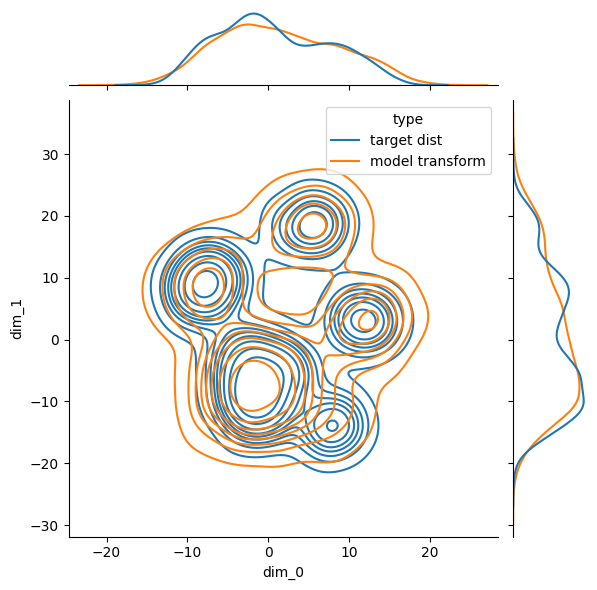

trail: 0 m step: 4 kl_test: 3.8114566802978516


  2%|▏         | 100/6000 [00:32<34:51,  2.82it/s]

trail: 0 m step: 5 Loss: 3.4336585998535156  L_n: 2.9930419921875  kld: 0.04406166076660156 KLD1: 2.8974812030792236 KLD2: 1.483594298362732


  3%|▎         | 200/6000 [01:04<34:18,  2.82it/s]

trail: 0 m step: 5 Loss: 3.2895259857177734  L_n: 2.865274429321289  kld: 0.04242515563964844 KLD1: 2.9141268730163574 KLD2: 1.4841423034667969


  5%|▌         | 300/6000 [01:36<33:41,  2.82it/s]

trail: 0 m step: 5 Loss: 3.3721179962158203  L_n: 2.8942508697509766  kld: 0.047786712646484375 KLD1: 2.8646507263183594 KLD2: 1.4804269075393677


  7%|▋         | 400/6000 [02:08<33:01,  2.83it/s]

trail: 0 m step: 5 Loss: 3.263246536254883  L_n: 2.830717086791992  kld: 0.04325294494628906 KLD1: 2.9208004474639893 KLD2: 1.457204818725586


  8%|▊         | 500/6000 [02:40<32:37,  2.81it/s]

trail: 0 m step: 5 Loss: 3.2696056365966797  L_n: 2.8534603118896484  kld: 0.041614532470703125 KLD1: 2.905690908432007 KLD2: 1.460565447807312


 10%|█         | 600/6000 [03:12<32:09,  2.80it/s]

trail: 0 m step: 5 Loss: 3.3492088317871094  L_n: 2.87933349609375  kld: 0.04698753356933594 KLD1: 2.8138976097106934 KLD2: 1.4418712854385376


 12%|█▏        | 700/6000 [03:44<31:19,  2.82it/s]

trail: 0 m step: 5 Loss: 3.3408355712890625  L_n: 2.8796768188476562  kld: 0.046115875244140625 KLD1: 2.8600573539733887 KLD2: 1.4631824493408203


 13%|█▎        | 800/6000 [04:16<30:53,  2.81it/s]

trail: 0 m step: 5 Loss: 3.2726612091064453  L_n: 2.8422489166259766  kld: 0.043041229248046875 KLD1: 2.8702306747436523 KLD2: 1.4559823274612427


 15%|█▌        | 900/6000 [04:48<30:12,  2.81it/s]

trail: 0 m step: 5 Loss: 3.230894088745117  L_n: 2.797677993774414  kld: 0.04332160949707031 KLD1: 2.8870277404785156 KLD2: 1.4384922981262207


 17%|█▋        | 1000/6000 [05:21<29:47,  2.80it/s]

trail: 0 m step: 5 Loss: 3.268817901611328  L_n: 2.8121986389160156  kld: 0.04566192626953125 KLD1: 2.817659616470337 KLD2: 1.4476637840270996


 18%|█▊        | 1100/6000 [05:53<29:06,  2.81it/s]

trail: 0 m step: 5 Loss: 3.3285083770751953  L_n: 2.8597774505615234  kld: 0.04687309265136719 KLD1: 2.834470510482788 KLD2: 1.429178237915039


 20%|██        | 1200/6000 [06:25<28:20,  2.82it/s]

trail: 0 m step: 5 Loss: 3.3037853240966797  L_n: 2.816915512084961  kld: 0.048686981201171875 KLD1: 2.768394708633423 KLD2: 1.4324190616607666


 22%|██▏       | 1300/6000 [06:57<27:49,  2.82it/s]

trail: 0 m step: 5 Loss: 3.2532081604003906  L_n: 2.7719459533691406  kld: 0.048126220703125 KLD1: 2.807110071182251 KLD2: 1.4333585500717163


 23%|██▎       | 1400/6000 [07:29<27:19,  2.81it/s]

trail: 0 m step: 5 Loss: 3.3294410705566406  L_n: 2.8148193359375  kld: 0.05146217346191406 KLD1: 2.8101847171783447 KLD2: 1.4338493347167969


 25%|██▌       | 1500/6000 [08:01<26:39,  2.81it/s]

trail: 0 m step: 5 Loss: 3.2024593353271484  L_n: 2.732278823852539  kld: 0.04701805114746094 KLD1: 2.7942702770233154 KLD2: 1.4508851766586304


 27%|██▋       | 1600/6000 [08:33<26:01,  2.82it/s]

trail: 0 m step: 5 Loss: 3.2968082427978516  L_n: 2.840188980102539  kld: 0.04566192626953125 KLD1: 2.7928943634033203 KLD2: 1.4433138370513916


 28%|██▊       | 1700/6000 [09:05<25:31,  2.81it/s]

trail: 0 m step: 5 Loss: 3.2829322814941406  L_n: 2.83056640625  kld: 0.04523658752441406 KLD1: 2.825944662094116 KLD2: 1.4261291027069092


 30%|███       | 1800/6000 [09:37<24:49,  2.82it/s]

trail: 0 m step: 5 Loss: 3.295198440551758  L_n: 2.7891979217529297  kld: 0.05060005187988281 KLD1: 2.7601158618927 KLD2: 1.4513866901397705


 32%|███▏      | 1900/6000 [10:09<24:13,  2.82it/s]

trail: 0 m step: 5 Loss: 3.3142051696777344  L_n: 2.809864044189453  kld: 0.050434112548828125 KLD1: 2.7968664169311523 KLD2: 1.4794819355010986


 33%|███▎      | 2000/6000 [10:42<23:44,  2.81it/s]

trail: 0 m step: 5 Loss: 3.3111915588378906  L_n: 2.818256378173828  kld: 0.04929351806640625 KLD1: 2.7772295475006104 KLD2: 1.4313209056854248


 35%|███▌      | 2100/6000 [11:14<23:05,  2.81it/s]

trail: 0 m step: 5 Loss: 3.1987533569335938  L_n: 2.7506027221679688  kld: 0.0448150634765625 KLD1: 2.7873945236206055 KLD2: 1.4272013902664185


 37%|███▋      | 2200/6000 [11:46<22:28,  2.82it/s]

trail: 0 m step: 5 Loss: 3.2607479095458984  L_n: 2.7928943634033203  kld: 0.04678535461425781 KLD1: 2.8067662715911865 KLD2: 1.4210911989212036


 38%|███▊      | 2300/6000 [12:18<21:54,  2.81it/s]

trail: 0 m step: 5 Loss: 3.2702369689941406  L_n: 2.792083740234375  kld: 0.04781532287597656 KLD1: 2.7927725315093994 KLD2: 1.4424781799316406


 40%|████      | 2400/6000 [12:50<21:21,  2.81it/s]

trail: 0 m step: 5 Loss: 3.2373790740966797  L_n: 2.760465621948242  kld: 0.04769134521484375 KLD1: 2.768866777420044 KLD2: 1.4212164878845215


 42%|████▏     | 2500/6000 [13:22<20:44,  2.81it/s]

trail: 0 m step: 5 Loss: 3.2686634063720703  L_n: 2.7669734954833984  kld: 0.05016899108886719 KLD1: 2.7500827312469482 KLD2: 1.4284512996673584


 43%|████▎     | 2600/6000 [13:54<20:06,  2.82it/s]

trail: 0 m step: 5 Loss: 3.245462417602539  L_n: 2.7430667877197266  kld: 0.05023956298828125 KLD1: 2.7335214614868164 KLD2: 1.4568568468093872


 45%|████▌     | 2700/6000 [14:26<19:28,  2.83it/s]

trail: 0 m step: 5 Loss: 3.304767608642578  L_n: 2.749652862548828  kld: 0.055511474609375 KLD1: 2.693969964981079 KLD2: 1.4220480918884277


 47%|████▋     | 2800/6000 [14:58<18:57,  2.81it/s]

trail: 0 m step: 5 Loss: 3.191499710083008  L_n: 2.7936649322509766  kld: 0.039783477783203125 KLD1: 2.845452070236206 KLD2: 1.4515783786773682


 48%|████▊     | 2900/6000 [15:30<18:19,  2.82it/s]

trail: 0 m step: 5 Loss: 3.301912307739258  L_n: 2.752595901489258  kld: 0.054931640625 KLD1: 2.7108888626098633 KLD2: 1.440105676651001


 50%|█████     | 3000/6000 [16:03<17:45,  2.82it/s]

trail: 0 m step: 5 Loss: 3.2036094665527344  L_n: 2.7356033325195312  kld: 0.04680061340332031 KLD1: 2.762824058532715 KLD2: 1.4306702613830566


 52%|█████▏    | 3100/6000 [16:35<17:10,  2.81it/s]

trail: 0 m step: 5 Loss: 3.1591720581054688  L_n: 2.7315635681152344  kld: 0.04276084899902344 KLD1: 2.8303463459014893 KLD2: 1.4305322170257568


 53%|█████▎    | 3200/6000 [17:07<16:33,  2.82it/s]

trail: 0 m step: 5 Loss: 3.2396411895751953  L_n: 2.715272903442383  kld: 0.05243682861328125 KLD1: 2.7210915088653564 KLD2: 1.4337819814682007


 55%|█████▌    | 3300/6000 [17:39<16:03,  2.80it/s]

trail: 0 m step: 5 Loss: 3.262575149536133  L_n: 2.772958755493164  kld: 0.048961639404296875 KLD1: 2.7279388904571533 KLD2: 1.4375720024108887


 57%|█████▋    | 3400/6000 [18:11<15:25,  2.81it/s]

trail: 0 m step: 5 Loss: 3.278818130493164  L_n: 2.845430374145508  kld: 0.043338775634765625 KLD1: 2.834716320037842 KLD2: 1.4370299577713013


 58%|█████▊    | 3500/6000 [18:43<14:47,  2.82it/s]

trail: 0 m step: 5 Loss: 3.223247528076172  L_n: 2.77923583984375  kld: 0.04440116882324219 KLD1: 2.80881929397583 KLD2: 1.4385672807693481


 60%|██████    | 3600/6000 [19:15<14:10,  2.82it/s]

trail: 0 m step: 5 Loss: 3.2562255859375  L_n: 2.7569198608398438  kld: 0.049930572509765625 KLD1: 2.7769343852996826 KLD2: 1.4502075910568237


 62%|██████▏   | 3700/6000 [19:47<13:40,  2.80it/s]

trail: 0 m step: 5 Loss: 3.2543563842773438  L_n: 2.7684974670410156  kld: 0.04858589172363281 KLD1: 2.7534098625183105 KLD2: 1.4335579872131348


 63%|██████▎   | 3800/6000 [20:19<13:02,  2.81it/s]

trail: 0 m step: 5 Loss: 3.2525882720947266  L_n: 2.771993637084961  kld: 0.04805946350097656 KLD1: 2.7959742546081543 KLD2: 1.450973391532898


 65%|██████▌   | 3900/6000 [20:51<12:26,  2.81it/s]

trail: 0 m step: 5 Loss: 3.2670536041259766  L_n: 2.7462329864501953  kld: 0.052082061767578125 KLD1: 2.6995158195495605 KLD2: 1.4428040981292725


 67%|██████▋   | 4000/6000 [21:23<11:50,  2.82it/s]

trail: 0 m step: 5 Loss: 3.2174930572509766  L_n: 2.759328842163086  kld: 0.04581642150878906 KLD1: 2.804861307144165 KLD2: 1.4297311305999756


 68%|██████▊   | 4100/6000 [21:56<11:14,  2.82it/s]

trail: 0 m step: 5 Loss: 3.1248416900634766  L_n: 2.721895217895508  kld: 0.040294647216796875 KLD1: 2.839116334915161 KLD2: 1.4422425031661987


 70%|███████   | 4200/6000 [22:28<10:38,  2.82it/s]

trail: 0 m step: 5 Loss: 3.1702880859375  L_n: 2.6985816955566406  kld: 0.04717063903808594 KLD1: 2.754592180252075 KLD2: 1.4508821964263916


 72%|███████▏  | 4300/6000 [23:00<10:02,  2.82it/s]

trail: 0 m step: 5 Loss: 3.258157730102539  L_n: 2.7504405975341797  kld: 0.05077171325683594 KLD1: 2.7219653129577637 KLD2: 1.4264661073684692


 73%|███████▎  | 4400/6000 [23:32<09:28,  2.81it/s]

trail: 0 m step: 5 Loss: 3.2345829010009766  L_n: 2.758871078491211  kld: 0.04757118225097656 KLD1: 2.742436170578003 KLD2: 1.4211599826812744


 75%|███████▌  | 4500/6000 [24:04<08:53,  2.81it/s]

trail: 0 m step: 5 Loss: 3.2272415161132812  L_n: 2.76318359375  kld: 0.046405792236328125 KLD1: 2.778985023498535 KLD2: 1.435907006263733


 77%|███████▋  | 4600/6000 [24:36<08:16,  2.82it/s]

trail: 0 m step: 5 Loss: 3.194721221923828  L_n: 2.709148406982422  kld: 0.048557281494140625 KLD1: 2.745483160018921 KLD2: 1.4357550144195557


 78%|███████▊  | 4700/6000 [25:08<07:42,  2.81it/s]

trail: 0 m step: 5 Loss: 3.304636001586914  L_n: 2.7726001739501953  kld: 0.053203582763671875 KLD1: 2.697544813156128 KLD2: 1.4379405975341797


 80%|████████  | 4800/6000 [25:40<07:07,  2.81it/s]

trail: 0 m step: 5 Loss: 3.1536006927490234  L_n: 2.7082347869873047  kld: 0.044536590576171875 KLD1: 2.7696280479431152 KLD2: 1.4184308052062988


 82%|████████▏ | 4900/6000 [26:12<06:30,  2.82it/s]

trail: 0 m step: 5 Loss: 3.22772216796875  L_n: 2.770111083984375  kld: 0.0457611083984375 KLD1: 2.783721923828125 KLD2: 1.4111335277557373


 83%|████████▎ | 5000/6000 [26:44<05:55,  2.82it/s]

trail: 0 m step: 5 Loss: 3.191530227661133  L_n: 2.7286548614501953  kld: 0.04628753662109375 KLD1: 2.755096435546875 KLD2: 1.418628454208374


 85%|████████▌ | 5100/6000 [27:16<05:20,  2.81it/s]

trail: 0 m step: 5 Loss: 3.257326126098633  L_n: 2.7486934661865234  kld: 0.05086326599121094 KLD1: 2.6808102130889893 KLD2: 1.4467709064483643


 87%|████████▋ | 5200/6000 [27:48<04:43,  2.82it/s]

trail: 0 m step: 5 Loss: 3.2057666778564453  L_n: 2.7239131927490234  kld: 0.04818534851074219 KLD1: 2.767908811569214 KLD2: 1.4231806993484497


 88%|████████▊ | 5300/6000 [28:20<04:08,  2.82it/s]

trail: 0 m step: 5 Loss: 3.2401199340820312  L_n: 2.750255584716797  kld: 0.04898643493652344 KLD1: 2.7527246475219727 KLD2: 1.4160305261611938


 90%|█████████ | 5400/6000 [28:52<03:32,  2.82it/s]

trail: 0 m step: 5 Loss: 3.2376441955566406  L_n: 2.73370361328125  kld: 0.05039405822753906 KLD1: 2.709074020385742 KLD2: 1.441251516342163


 92%|█████████▏| 5500/6000 [29:25<02:57,  2.81it/s]

trail: 0 m step: 5 Loss: 3.2353649139404297  L_n: 2.7522335052490234  kld: 0.048313140869140625 KLD1: 2.7345621585845947 KLD2: 1.4084097146987915


 93%|█████████▎| 5600/6000 [29:57<02:22,  2.81it/s]

trail: 0 m step: 5 Loss: 3.2521114349365234  L_n: 2.734457015991211  kld: 0.05176544189453125 KLD1: 2.672699451446533 KLD2: 1.4188311100006104


 95%|█████████▌| 5700/6000 [30:29<01:46,  2.82it/s]

trail: 0 m step: 5 Loss: 3.1904468536376953  L_n: 2.680746078491211  kld: 0.05097007751464844 KLD1: 2.7020957469940186 KLD2: 1.4291852712631226


 97%|█████████▋| 5800/6000 [31:01<01:11,  2.81it/s]

trail: 0 m step: 5 Loss: 3.2487831115722656  L_n: 2.736164093017578  kld: 0.05126190185546875 KLD1: 2.7350523471832275 KLD2: 1.4108763933181763


 98%|█████████▊| 5900/6000 [31:33<00:35,  2.81it/s]

trail: 0 m step: 5 Loss: 3.2953872680664062  L_n: 2.7273025512695312  kld: 0.0568084716796875 KLD1: 2.6520581245422363 KLD2: 1.4268548488616943


100%|██████████| 6000/6000 [32:05<00:00,  3.12it/s]

trail: 0 m step: 5 Loss: 3.207174301147461  L_n: 2.731290817260742  kld: 0.047588348388671875 KLD1: 2.7257609367370605 KLD2: 1.42143976688385



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


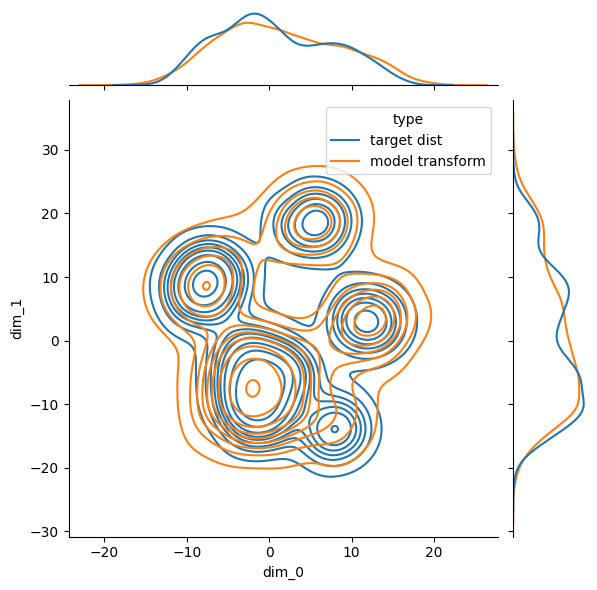

trail: 0 m step: 5 kl_test: 2.719493865966797


  2%|▏         | 100/6000 [00:31<34:49,  2.82it/s]

trail: 0 m step: 6 Loss: 2.497509002685547  L_n: 2.2001914978027344  kld: 0.02973175048828125 KLD1: 2.1306991577148438 KLD2: 1.1683775186538696


  3%|▎         | 200/6000 [01:03<34:12,  2.83it/s]

trail: 0 m step: 6 Loss: 2.3850173950195312  L_n: 2.099163055419922  kld: 0.028585433959960938 KLD1: 2.1447696685791016 KLD2: 1.1705420017242432


  5%|▌         | 300/6000 [01:35<33:30,  2.84it/s]

trail: 0 m step: 6 Loss: 2.4762725830078125  L_n: 2.149200439453125  kld: 0.03270721435546875 KLD1: 2.082838535308838 KLD2: 1.165761113166809


  7%|▋         | 400/6000 [02:07<32:59,  2.83it/s]

trail: 0 m step: 6 Loss: 2.3827781677246094  L_n: 2.0888938903808594  kld: 0.029388427734375 KLD1: 2.1511130332946777 KLD2: 1.1470046043395996


  8%|▊         | 500/6000 [02:39<32:25,  2.83it/s]

trail: 0 m step: 6 Loss: 2.371389389038086  L_n: 2.0899219512939453  kld: 0.028146743774414062 KLD1: 2.156151294708252 KLD2: 1.150833010673523


 10%|█         | 600/6000 [03:11<31:46,  2.83it/s]

trail: 0 m step: 6 Loss: 2.4427871704101562  L_n: 2.1300010681152344  kld: 0.03127861022949219 KLD1: 2.1144838333129883 KLD2: 1.1407214403152466


 12%|█▏        | 700/6000 [03:43<31:18,  2.82it/s]

trail: 0 m step: 6 Loss: 2.446563720703125  L_n: 2.1025733947753906  kld: 0.03439903259277344 KLD1: 2.0886898040771484 KLD2: 1.1604470014572144


 13%|█▎        | 800/6000 [04:15<30:41,  2.82it/s]

trail: 0 m step: 6 Loss: 2.3832130432128906  L_n: 2.0938873291015625  kld: 0.028932571411132812 KLD1: 2.1091105937957764 KLD2: 1.1484111547470093


 15%|█▌        | 900/6000 [04:47<29:55,  2.84it/s]

trail: 0 m step: 6 Loss: 2.339944839477539  L_n: 2.062845230102539  kld: 0.0277099609375 KLD1: 2.1377363204956055 KLD2: 1.1375150680541992


 17%|█▋        | 1000/6000 [05:19<29:25,  2.83it/s]

trail: 0 m step: 6 Loss: 2.3924388885498047  L_n: 2.0730342864990234  kld: 0.031940460205078125 KLD1: 2.084770679473877 KLD2: 1.1433384418487549


 18%|█▊        | 1100/6000 [05:51<28:58,  2.82it/s]

trail: 0 m step: 6 Loss: 2.3980751037597656  L_n: 2.0899429321289062  kld: 0.030813217163085938 KLD1: 2.087682008743286 KLD2: 1.1248431205749512


 20%|██        | 1200/6000 [06:23<28:18,  2.83it/s]

trail: 0 m step: 6 Loss: 2.387561798095703  L_n: 2.0563507080078125  kld: 0.03312110900878906 KLD1: 2.0559422969818115 KLD2: 1.1342236995697021


 22%|██▏       | 1300/6000 [06:55<27:39,  2.83it/s]

trail: 0 m step: 6 Loss: 2.374256134033203  L_n: 2.052257537841797  kld: 0.032199859619140625 KLD1: 2.0575177669525146 KLD2: 1.1306126117706299


 23%|██▎       | 1400/6000 [07:27<27:07,  2.83it/s]

trail: 0 m step: 6 Loss: 2.4777450561523438  L_n: 2.1109046936035156  kld: 0.03668403625488281 KLD1: 2.0466630458831787 KLD2: 1.1297188997268677


 25%|██▌       | 1500/6000 [07:59<26:31,  2.83it/s]

trail: 0 m step: 6 Loss: 2.339570999145508  L_n: 2.023427963256836  kld: 0.03161430358886719 KLD1: 2.040123701095581 KLD2: 1.1487541198730469


 27%|██▋       | 1600/6000 [08:31<25:53,  2.83it/s]

trail: 0 m step: 6 Loss: 2.3867149353027344  L_n: 2.079021453857422  kld: 0.03076934814453125 KLD1: 2.0467560291290283 KLD2: 1.1375746726989746


 28%|██▊       | 1700/6000 [09:03<25:17,  2.83it/s]

trail: 0 m step: 6 Loss: 2.3827571868896484  L_n: 2.0954723358154297  kld: 0.028728485107421875 KLD1: 2.0947484970092773 KLD2: 1.127035140991211


 30%|███       | 1800/6000 [09:35<24:46,  2.83it/s]

trail: 0 m step: 6 Loss: 2.395143508911133  L_n: 2.048978805541992  kld: 0.03461647033691406 KLD1: 2.0255377292633057 KLD2: 1.1489253044128418


 32%|███▏      | 1900/6000 [10:07<24:09,  2.83it/s]

trail: 0 m step: 6 Loss: 2.420625686645508  L_n: 2.0879268646240234  kld: 0.03326988220214844 KLD1: 2.0666792392730713 KLD2: 1.1728876829147339


 33%|███▎      | 2000/6000 [10:39<23:34,  2.83it/s]

trail: 0 m step: 6 Loss: 2.4082679748535156  L_n: 2.087757110595703  kld: 0.03205108642578125 KLD1: 2.052841901779175 KLD2: 1.1338950395584106


 35%|███▌      | 2100/6000 [11:11<22:57,  2.83it/s]

trail: 0 m step: 6 Loss: 2.3548583984375  L_n: 2.0672683715820312  kld: 0.028759002685546875 KLD1: 2.098416328430176 KLD2: 1.128501296043396


 37%|███▋      | 2200/6000 [11:43<22:27,  2.82it/s]

trail: 0 m step: 6 Loss: 2.3587646484375  L_n: 2.0426788330078125  kld: 0.03160858154296875 KLD1: 2.0582544803619385 KLD2: 1.121301531791687


 38%|███▊      | 2300/6000 [12:15<21:51,  2.82it/s]

trail: 0 m step: 6 Loss: 2.36407470703125  L_n: 2.049571990966797  kld: 0.03145027160644531 KLD1: 2.0407307147979736 KLD2: 1.1440644264221191


 40%|████      | 2400/6000 [12:47<21:16,  2.82it/s]

trail: 0 m step: 6 Loss: 2.333433151245117  L_n: 2.025320053100586  kld: 0.030811309814453125 KLD1: 2.057839870452881 KLD2: 1.123572587966919


 42%|████▏     | 2500/6000 [13:19<20:37,  2.83it/s]

trail: 0 m step: 6 Loss: 2.3737564086914062  L_n: 2.0405616760253906  kld: 0.03331947326660156 KLD1: 1.986619472503662 KLD2: 1.1310367584228516


 43%|████▎     | 2600/6000 [13:51<19:56,  2.84it/s]

trail: 0 m step: 6 Loss: 2.3750267028808594  L_n: 2.045055389404297  kld: 0.03299713134765625 KLD1: 2.0201849937438965 KLD2: 1.1603727340698242


 45%|████▌     | 2700/6000 [14:23<19:22,  2.84it/s]

trail: 0 m step: 6 Loss: 2.4109668731689453  L_n: 2.0372791290283203  kld: 0.0373687744140625 KLD1: 1.9776036739349365 KLD2: 1.1272270679473877


 47%|████▋     | 2800/6000 [14:55<18:51,  2.83it/s]

trail: 0 m step: 6 Loss: 2.3403244018554688  L_n: 2.0938568115234375  kld: 0.024646759033203125 KLD1: 2.121760129928589 KLD2: 1.1505699157714844


 48%|████▊     | 2900/6000 [15:27<18:12,  2.84it/s]

trail: 0 m step: 6 Loss: 2.4199371337890625  L_n: 2.046916961669922  kld: 0.03730201721191406 KLD1: 2.009683132171631 KLD2: 1.147411584854126


 50%|█████     | 3000/6000 [15:59<17:41,  2.83it/s]

trail: 0 m step: 6 Loss: 2.3202476501464844  L_n: 2.0178756713867188  kld: 0.030237197875976562 KLD1: 2.0329136848449707 KLD2: 1.1336593627929688


 52%|█████▏    | 3100/6000 [16:31<17:01,  2.84it/s]

trail: 0 m step: 6 Loss: 2.2837467193603516  L_n: 2.0159358978271484  kld: 0.026781082153320312 KLD1: 2.1025784015655518 KLD2: 1.134290337562561


 53%|█████▎    | 3200/6000 [17:03<16:31,  2.82it/s]

trail: 0 m step: 6 Loss: 2.355113983154297  L_n: 1.9889411926269531  kld: 0.036617279052734375 KLD1: 1.9860950708389282 KLD2: 1.135191798210144


 55%|█████▌    | 3300/6000 [17:34<15:54,  2.83it/s]

trail: 0 m step: 6 Loss: 2.4056339263916016  L_n: 2.0775699615478516  kld: 0.032806396484375 KLD1: 2.0112948417663574 KLD2: 1.1374866962432861


 57%|█████▋    | 3400/6000 [18:06<15:47,  2.74it/s]

trail: 0 m step: 6 Loss: 2.374582290649414  L_n: 2.0958423614501953  kld: 0.027873992919921875 KLD1: 2.1091535091400146 KLD2: 1.137853741645813


 58%|█████▊    | 3500/6000 [18:38<14:41,  2.84it/s]

trail: 0 m step: 6 Loss: 2.336292266845703  L_n: 2.0526695251464844  kld: 0.028362274169921875 KLD1: 2.086704730987549 KLD2: 1.1348565816879272


 60%|██████    | 3600/6000 [19:10<14:07,  2.83it/s]

trail: 0 m step: 6 Loss: 2.3737525939941406  L_n: 2.0468521118164062  kld: 0.03269004821777344 KLD1: 2.0605807304382324 KLD2: 1.1517059803009033


 62%|██████▏   | 3700/6000 [19:42<13:33,  2.83it/s]

trail: 0 m step: 6 Loss: 2.3492660522460938  L_n: 2.0325698852539062  kld: 0.03166961669921875 KLD1: 2.0385375022888184 KLD2: 1.1336859464645386


 63%|██████▎   | 3800/6000 [20:14<13:00,  2.82it/s]

trail: 0 m step: 6 Loss: 2.3676509857177734  L_n: 2.039682388305664  kld: 0.03279685974121094 KLD1: 2.0696969032287598 KLD2: 1.1520283222198486


 65%|██████▌   | 3900/6000 [20:46<12:21,  2.83it/s]

trail: 0 m step: 6 Loss: 2.4019336700439453  L_n: 2.057943344116211  kld: 0.03439903259277344 KLD1: 1.9918559789657593 KLD2: 1.1423364877700806


 67%|██████▋   | 4000/6000 [21:18<11:49,  2.82it/s]

trail: 0 m step: 6 Loss: 2.353425979614258  L_n: 2.0419178009033203  kld: 0.03115081787109375 KLD1: 2.0603322982788086 KLD2: 1.129891276359558


 68%|██████▊   | 4100/6000 [21:50<11:11,  2.83it/s]

trail: 0 m step: 6 Loss: 2.2600440979003906  L_n: 1.9974021911621094  kld: 0.026264190673828125 KLD1: 2.108198881149292 KLD2: 1.1440279483795166


 70%|███████   | 4200/6000 [22:22<10:37,  2.82it/s]

trail: 0 m step: 6 Loss: 2.293506622314453  L_n: 1.9889984130859375  kld: 0.030450820922851562 KLD1: 2.0369510650634766 KLD2: 1.1502197980880737


 72%|███████▏  | 4300/6000 [22:54<10:01,  2.83it/s]

trail: 0 m step: 6 Loss: 2.3455886840820312  L_n: 2.010753631591797  kld: 0.03348350524902344 KLD1: 1.9967727661132812 KLD2: 1.1309200525283813


 73%|███████▎  | 4400/6000 [23:26<09:25,  2.83it/s]

trail: 0 m step: 6 Loss: 2.391519546508789  L_n: 2.069406509399414  kld: 0.0322113037109375 KLD1: 2.008942127227783 KLD2: 1.1267040967941284


 75%|███████▌  | 4500/6000 [23:58<08:50,  2.83it/s]

trail: 0 m step: 6 Loss: 2.3377857208251953  L_n: 2.0347843170166016  kld: 0.030300140380859375 KLD1: 2.0954508781433105 KLD2: 1.1391818523406982


 77%|███████▋  | 4600/6000 [24:30<08:16,  2.82it/s]

trail: 0 m step: 6 Loss: 2.304576873779297  L_n: 1.9948997497558594  kld: 0.03096771240234375 KLD1: 2.0491323471069336 KLD2: 1.1394340991973877


 78%|███████▊  | 4700/6000 [25:02<07:40,  2.82it/s]

trail: 0 m step: 6 Loss: 2.359243392944336  L_n: 2.008768081665039  kld: 0.03504753112792969 KLD1: 1.9903515577316284 KLD2: 1.1391561031341553


 80%|████████  | 4800/6000 [25:34<07:05,  2.82it/s]

trail: 0 m step: 6 Loss: 2.3091659545898438  L_n: 2.0125160217285156  kld: 0.029664993286132812 KLD1: 2.0322229862213135 KLD2: 1.1205945014953613


 82%|████████▏ | 4900/6000 [26:06<06:29,  2.83it/s]

trail: 0 m step: 6 Loss: 2.3766613006591797  L_n: 2.073373794555664  kld: 0.030328750610351562 KLD1: 2.0554964542388916 KLD2: 1.112354040145874


 83%|████████▎ | 5000/6000 [26:38<05:53,  2.83it/s]

trail: 0 m step: 6 Loss: 2.297893524169922  L_n: 1.9966659545898438  kld: 0.030122756958007812 KLD1: 2.04563045501709 KLD2: 1.1187188625335693


 85%|████████▌ | 5100/6000 [27:10<05:17,  2.84it/s]

trail: 0 m step: 6 Loss: 2.3391056060791016  L_n: 2.0085811614990234  kld: 0.03305244445800781 KLD1: 1.9895576238632202 KLD2: 1.1454365253448486


 87%|████████▋ | 5200/6000 [27:42<04:43,  2.82it/s]

trail: 0 m step: 6 Loss: 2.35174560546875  L_n: 2.0246543884277344  kld: 0.03270912170410156 KLD1: 2.040583610534668 KLD2: 1.1268279552459717


 88%|████████▊ | 5300/6000 [28:14<04:08,  2.82it/s]

trail: 0 m step: 6 Loss: 2.357400894165039  L_n: 2.0338191986083984  kld: 0.03235816955566406 KLD1: 2.0235581398010254 KLD2: 1.1210484504699707


 90%|█████████ | 5400/6000 [28:46<03:31,  2.83it/s]

trail: 0 m step: 6 Loss: 2.3568973541259766  L_n: 2.018495559692383  kld: 0.033840179443359375 KLD1: 1.9713144302368164 KLD2: 1.1433498859405518


 92%|█████████▏| 5500/6000 [29:18<02:56,  2.83it/s]

trail: 0 m step: 6 Loss: 2.313749313354492  L_n: 1.9999713897705078  kld: 0.03137779235839844 KLD1: 2.0251684188842773 KLD2: 1.1155515909194946


 93%|█████████▎| 5600/6000 [29:50<02:21,  2.84it/s]

trail: 0 m step: 6 Loss: 2.4189224243164062  L_n: 2.073444366455078  kld: 0.03454780578613281 KLD1: 2.0011093616485596 KLD2: 1.1233575344085693


 95%|█████████▌| 5700/6000 [30:22<01:46,  2.83it/s]

trail: 0 m step: 6 Loss: 2.302152633666992  L_n: 1.9620342254638672  kld: 0.0340118408203125 KLD1: 1.994748830795288 KLD2: 1.130900502204895


 97%|█████████▋| 5800/6000 [30:54<01:10,  2.84it/s]

trail: 0 m step: 6 Loss: 2.3675594329833984  L_n: 2.027059555053711  kld: 0.03404998779296875 KLD1: 2.0130069255828857 KLD2: 1.1136025190353394


 98%|█████████▊| 5900/6000 [31:26<00:35,  2.83it/s]

trail: 0 m step: 6 Loss: 2.4058361053466797  L_n: 2.0208187103271484  kld: 0.038501739501953125 KLD1: 1.9650038480758667 KLD2: 1.1309394836425781


100%|██████████| 6000/6000 [31:58<00:00,  3.13it/s]

trail: 0 m step: 6 Loss: 2.3408374786376953  L_n: 2.0279369354248047  kld: 0.03129005432128906 KLD1: 2.0125620365142822 KLD2: 1.128597617149353



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


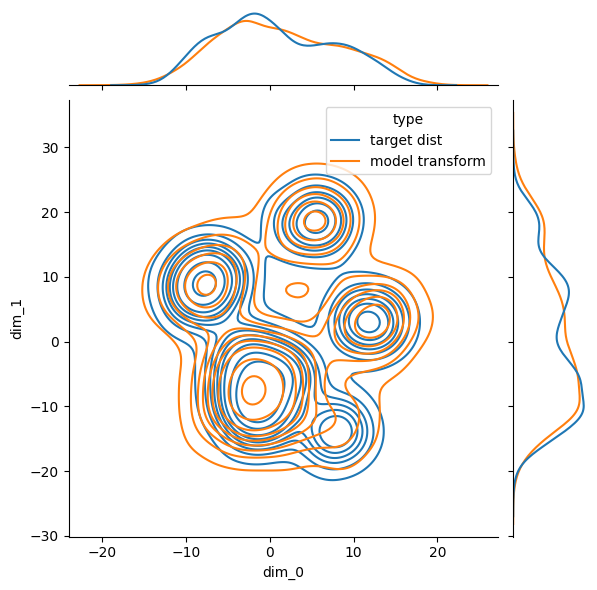

trail: 0 m step: 6 kl_test: 2.000345230102539


  2%|▏         | 100/6000 [00:31<34:45,  2.83it/s]

trail: 0 m step: 7 Loss: 1.895425796508789  L_n: 1.6832904815673828  kld: 0.021213531494140625 KLD1: 1.6399606466293335 KLD2: 0.9470875859260559


  3%|▎         | 200/6000 [01:03<34:18,  2.82it/s]

trail: 0 m step: 7 Loss: 1.8106212615966797  L_n: 1.6018619537353516  kld: 0.020875930786132812 KLD1: 1.614610195159912 KLD2: 0.9461807608604431


  5%|▌         | 300/6000 [01:35<33:34,  2.83it/s]

trail: 0 m step: 7 Loss: 1.894216537475586  L_n: 1.6496562957763672  kld: 0.024456024169921875 KLD1: 1.6027382612228394 KLD2: 0.9373384714126587


  7%|▋         | 400/6000 [02:07<33:03,  2.82it/s]

trail: 0 m step: 7 Loss: 1.803884506225586  L_n: 1.599283218383789  kld: 0.020460128784179688 KLD1: 1.6328794956207275 KLD2: 0.9233281016349792


  8%|▊         | 500/6000 [02:39<32:30,  2.82it/s]

trail: 0 m step: 7 Loss: 1.8076648712158203  L_n: 1.6098918914794922  kld: 0.019777297973632812 KLD1: 1.6360925436019897 KLD2: 0.9258692860603333


 10%|█         | 600/6000 [03:12<31:58,  2.81it/s]

trail: 0 m step: 7 Loss: 1.8336448669433594  L_n: 1.6293869018554688  kld: 0.020425796508789062 KLD1: 1.5972986221313477 KLD2: 0.9174788594245911


 12%|█▏        | 700/6000 [03:44<31:13,  2.83it/s]

trail: 0 m step: 7 Loss: 1.8404865264892578  L_n: 1.5981769561767578  kld: 0.02423095703125 KLD1: 1.5830554962158203 KLD2: 0.9286216497421265


 13%|█▎        | 800/6000 [04:16<30:38,  2.83it/s]

trail: 0 m step: 7 Loss: 1.8142108917236328  L_n: 1.610391616821289  kld: 0.020381927490234375 KLD1: 1.6271896362304688 KLD2: 0.924543559551239


 15%|█▌        | 900/6000 [04:48<30:11,  2.81it/s]

trail: 0 m step: 7 Loss: 1.7710304260253906  L_n: 1.5618324279785156  kld: 0.0209197998046875 KLD1: 1.6052203178405762 KLD2: 0.9174495935440063


 17%|█▋        | 1000/6000 [05:20<29:32,  2.82it/s]

trail: 0 m step: 7 Loss: 1.8218822479248047  L_n: 1.5897579193115234  kld: 0.023212432861328125 KLD1: 1.5746703147888184 KLD2: 0.9188488125801086


 18%|█▊        | 1100/6000 [05:52<29:02,  2.81it/s]

trail: 0 m step: 7 Loss: 1.8225250244140625  L_n: 1.6171226501464844  kld: 0.020540237426757812 KLD1: 1.6058268547058105 KLD2: 0.9104305505752563


 20%|██        | 1200/6000 [06:24<28:20,  2.82it/s]

trail: 0 m step: 7 Loss: 1.7953071594238281  L_n: 1.5626106262207031  kld: 0.0232696533203125 KLD1: 1.557172179222107 KLD2: 0.9116512537002563


 22%|██▏       | 1300/6000 [06:56<27:44,  2.82it/s]

trail: 0 m step: 7 Loss: 1.7904491424560547  L_n: 1.5455074310302734  kld: 0.024494171142578125 KLD1: 1.5422968864440918 KLD2: 0.9099796414375305


 23%|██▎       | 1400/6000 [07:28<27:12,  2.82it/s]

trail: 0 m step: 7 Loss: 1.8836078643798828  L_n: 1.6098461151123047  kld: 0.027376174926757812 KLD1: 1.555398941040039 KLD2: 0.9086541533470154


 25%|██▌       | 1500/6000 [08:00<26:38,  2.82it/s]

trail: 0 m step: 7 Loss: 1.7891254425048828  L_n: 1.5604724884033203  kld: 0.02286529541015625 KLD1: 1.5731632709503174 KLD2: 0.9316314458847046


 27%|██▋       | 1600/6000 [08:32<26:02,  2.82it/s]

trail: 0 m step: 7 Loss: 1.8003730773925781  L_n: 1.583526611328125  kld: 0.021684646606445312 KLD1: 1.5936506986618042 KLD2: 0.9193447232246399


 28%|██▊       | 1700/6000 [09:04<25:23,  2.82it/s]

trail: 0 m step: 7 Loss: 1.7981948852539062  L_n: 1.5869178771972656  kld: 0.021127700805664062 KLD1: 1.583613395690918 KLD2: 0.9101778864860535


 30%|███       | 1800/6000 [09:36<24:48,  2.82it/s]

trail: 0 m step: 7 Loss: 1.8105525970458984  L_n: 1.551095962524414  kld: 0.025945663452148438 KLD1: 1.5563746690750122 KLD2: 0.9280245900154114


 32%|███▏      | 1900/6000 [10:08<24:17,  2.81it/s]

trail: 0 m step: 7 Loss: 1.83929443359375  L_n: 1.6052436828613281  kld: 0.023405075073242188 KLD1: 1.5545836687088013 KLD2: 0.9498632550239563


 33%|███▎      | 2000/6000 [10:40<23:40,  2.82it/s]

trail: 0 m step: 7 Loss: 1.8134346008300781  L_n: 1.5835418701171875  kld: 0.022989273071289062 KLD1: 1.5433650016784668 KLD2: 0.9086481928825378


 35%|███▌      | 2100/6000 [11:12<23:03,  2.82it/s]

trail: 0 m step: 7 Loss: 1.7789955139160156  L_n: 1.5819473266601562  kld: 0.019704818725585938 KLD1: 1.58112633228302 KLD2: 0.9114003777503967


 37%|███▋      | 2200/6000 [11:44<22:22,  2.83it/s]

trail: 0 m step: 7 Loss: 1.7438983917236328  L_n: 1.5210247039794922  kld: 0.022287368774414062 KLD1: 1.5643038749694824 KLD2: 0.9024152159690857


 38%|███▊      | 2300/6000 [12:16<21:50,  2.82it/s]

trail: 0 m step: 7 Loss: 1.7834548950195312  L_n: 1.5620498657226562  kld: 0.0221405029296875 KLD1: 1.5472890138626099 KLD2: 0.9262791872024536


 40%|████      | 2400/6000 [12:49<21:19,  2.81it/s]

trail: 0 m step: 7 Loss: 1.7592334747314453  L_n: 1.5511417388916016  kld: 0.020809173583984375 KLD1: 1.5840339660644531 KLD2: 0.902491569519043


 42%|████▏     | 2500/6000 [13:21<20:46,  2.81it/s]

trail: 0 m step: 7 Loss: 1.8011970520019531  L_n: 1.5587348937988281  kld: 0.0242462158203125 KLD1: 1.5107150077819824 KLD2: 0.9117112159729004


 43%|████▎     | 2600/6000 [13:53<20:05,  2.82it/s]

trail: 0 m step: 7 Loss: 1.7873897552490234  L_n: 1.551279067993164  kld: 0.023611068725585938 KLD1: 1.5471856594085693 KLD2: 0.9392986297607422


 45%|████▌     | 2700/6000 [14:25<19:33,  2.81it/s]

trail: 0 m step: 7 Loss: 1.7970752716064453  L_n: 1.5374088287353516  kld: 0.025966644287109375 KLD1: 1.5120916366577148 KLD2: 0.9085216522216797


 47%|████▋     | 2800/6000 [14:57<18:53,  2.82it/s]

trail: 0 m step: 7 Loss: 1.7814006805419922  L_n: 1.6094532012939453  kld: 0.017194747924804688 KLD1: 1.6060770750045776 KLD2: 0.9286255836486816


 48%|████▊     | 2900/6000 [15:29<18:15,  2.83it/s]

trail: 0 m step: 7 Loss: 1.8129844665527344  L_n: 1.5379829406738281  kld: 0.027500152587890625 KLD1: 1.5078881978988647 KLD2: 0.9228185415267944


 50%|█████     | 3000/6000 [16:01<17:42,  2.82it/s]

trail: 0 m step: 7 Loss: 1.7734413146972656  L_n: 1.5575675964355469  kld: 0.021587371826171875 KLD1: 1.5627583265304565 KLD2: 0.9124037623405457


 52%|█████▏    | 3100/6000 [16:33<17:11,  2.81it/s]

trail: 0 m step: 7 Loss: 1.700357437133789  L_n: 1.5278377532958984  kld: 0.017251968383789062 KLD1: 1.607558012008667 KLD2: 0.9140377640724182


 53%|█████▎    | 3200/6000 [17:05<16:36,  2.81it/s]

trail: 0 m step: 7 Loss: 1.792633056640625  L_n: 1.5290565490722656  kld: 0.026357650756835938 KLD1: 1.5213024616241455 KLD2: 0.9138568043708801


 55%|█████▌    | 3300/6000 [17:37<15:55,  2.83it/s]

trail: 0 m step: 7 Loss: 1.7930927276611328  L_n: 1.5641918182373047  kld: 0.022890090942382812 KLD1: 1.5315098762512207 KLD2: 0.915101170539856


 57%|█████▋    | 3400/6000 [18:09<15:17,  2.83it/s]

trail: 0 m step: 7 Loss: 1.7963066101074219  L_n: 1.5974464416503906  kld: 0.019886016845703125 KLD1: 1.6179652214050293 KLD2: 0.9134958982467651


 58%|█████▊    | 3500/6000 [18:41<14:46,  2.82it/s]

trail: 0 m step: 7 Loss: 1.7381343841552734  L_n: 1.543661117553711  kld: 0.01944732666015625 KLD1: 1.5899646282196045 KLD2: 0.9134663939476013


 60%|██████    | 3600/6000 [19:13<14:11,  2.82it/s]

trail: 0 m step: 7 Loss: 1.7742176055908203  L_n: 1.5525836944580078  kld: 0.02216339111328125 KLD1: 1.5686341524124146 KLD2: 0.9272742867469788


 62%|██████▏   | 3700/6000 [19:45<13:34,  2.82it/s]

trail: 0 m step: 7 Loss: 1.7829666137695312  L_n: 1.5644035339355469  kld: 0.021856307983398438 KLD1: 1.5477913618087769 KLD2: 0.9104107022285461


 63%|██████▎   | 3800/6000 [20:17<12:59,  2.82it/s]

trail: 0 m step: 7 Loss: 1.776845932006836  L_n: 1.5607242584228516  kld: 0.021612167358398438 KLD1: 1.5865105390548706 KLD2: 0.9280663728713989


 65%|██████▌   | 3900/6000 [20:49<12:23,  2.83it/s]

trail: 0 m step: 7 Loss: 1.8225841522216797  L_n: 1.5778331756591797  kld: 0.02447509765625 KLD1: 1.5254528522491455 KLD2: 0.9259144067764282


 67%|██████▋   | 4000/6000 [21:21<11:49,  2.82it/s]

trail: 0 m step: 7 Loss: 1.759408950805664  L_n: 1.5462818145751953  kld: 0.021312713623046875 KLD1: 1.5692754983901978 KLD2: 0.9095505475997925


 68%|██████▊   | 4100/6000 [21:53<11:15,  2.81it/s]

trail: 0 m step: 7 Loss: 1.7011966705322266  L_n: 1.5195598602294922  kld: 0.018163681030273438 KLD1: 1.5961532592773438 KLD2: 0.9221534729003906


 70%|███████   | 4200/6000 [22:25<10:38,  2.82it/s]

trail: 0 m step: 7 Loss: 1.7296180725097656  L_n: 1.5206871032714844  kld: 0.020893096923828125 KLD1: 1.5541702508926392 KLD2: 0.9292627573013306


 72%|███████▏  | 4300/6000 [22:57<10:03,  2.82it/s]

trail: 0 m step: 7 Loss: 1.774078369140625  L_n: 1.5461692810058594  kld: 0.022790908813476562 KLD1: 1.5525325536727905 KLD2: 0.9119570255279541


 73%|███████▎  | 4400/6000 [23:29<09:26,  2.83it/s]

trail: 0 m step: 7 Loss: 1.7918014526367188  L_n: 1.5770721435546875  kld: 0.021472930908203125 KLD1: 1.5457974672317505 KLD2: 0.9101529121398926


 75%|███████▌  | 4500/6000 [24:01<08:50,  2.82it/s]

trail: 0 m step: 7 Loss: 1.7846508026123047  L_n: 1.5670413970947266  kld: 0.021760940551757812 KLD1: 1.5918382406234741 KLD2: 0.9206985831260681


 77%|███████▋  | 4600/6000 [24:33<08:14,  2.83it/s]

trail: 0 m step: 7 Loss: 1.7460708618164062  L_n: 1.5295867919921875  kld: 0.021648406982421875 KLD1: 1.5367934703826904 KLD2: 0.9191214442253113


 78%|███████▊  | 4700/6000 [25:05<07:40,  2.82it/s]

trail: 0 m step: 7 Loss: 1.7934608459472656  L_n: 1.5445899963378906  kld: 0.0248870849609375 KLD1: 1.5206173658370972 KLD2: 0.9194227457046509


 80%|████████  | 4800/6000 [25:37<07:05,  2.82it/s]

trail: 0 m step: 7 Loss: 1.7442626953125  L_n: 1.5369720458984375  kld: 0.02072906494140625 KLD1: 1.5415552854537964 KLD2: 0.9018962383270264


 82%|████████▏ | 4900/6000 [26:09<06:29,  2.83it/s]

trail: 0 m step: 7 Loss: 1.7766952514648438  L_n: 1.5658950805664062  kld: 0.02108001708984375 KLD1: 1.5685641765594482 KLD2: 0.8947542905807495


 83%|████████▎ | 5000/6000 [26:41<05:54,  2.82it/s]

trail: 0 m step: 7 Loss: 1.7434883117675781  L_n: 1.5335273742675781  kld: 0.02099609375 KLD1: 1.554462194442749 KLD2: 0.8995617032051086


 85%|████████▌ | 5100/6000 [27:13<05:19,  2.82it/s]

trail: 0 m step: 7 Loss: 1.7560272216796875  L_n: 1.5287857055664062  kld: 0.022724151611328125 KLD1: 1.5380017757415771 KLD2: 0.927476167678833


 87%|████████▋ | 5200/6000 [27:45<04:43,  2.82it/s]

trail: 0 m step: 7 Loss: 1.7723560333251953  L_n: 1.5384769439697266  kld: 0.023387908935546875 KLD1: 1.5545954704284668 KLD2: 0.907187283039093


 88%|████████▊ | 5300/6000 [28:18<04:08,  2.82it/s]

trail: 0 m step: 7 Loss: 1.7598381042480469  L_n: 1.53814697265625  kld: 0.022169113159179688 KLD1: 1.5357136726379395 KLD2: 0.9004743695259094


 90%|█████████ | 5400/6000 [28:50<03:31,  2.83it/s]

trail: 0 m step: 7 Loss: 1.7767314910888672  L_n: 1.5387134552001953  kld: 0.023801803588867188 KLD1: 1.5240036249160767 KLD2: 0.9223951697349548


 92%|█████████▏| 5500/6000 [29:21<02:57,  2.82it/s]

trail: 0 m step: 7 Loss: 1.7443618774414062  L_n: 1.5341339111328125  kld: 0.021022796630859375 KLD1: 1.5445159673690796 KLD2: 0.8968562483787537


 93%|█████████▎| 5600/6000 [29:53<02:22,  2.82it/s]

trail: 0 m step: 7 Loss: 1.807332992553711  L_n: 1.558481216430664  kld: 0.024885177612304688 KLD1: 1.5176503658294678 KLD2: 0.9057376980781555


 95%|█████████▌| 5700/6000 [30:25<01:46,  2.82it/s]

trail: 0 m step: 7 Loss: 1.7415885925292969  L_n: 1.5071754455566406  kld: 0.023441314697265625 KLD1: 1.5200655460357666 KLD2: 0.9091616272926331


 97%|█████████▋| 5800/6000 [30:57<01:10,  2.82it/s]

trail: 0 m step: 7 Loss: 1.7860069274902344  L_n: 1.5521278381347656  kld: 0.023387908935546875 KLD1: 1.528211236000061 KLD2: 0.8953336477279663


 98%|█████████▊| 5900/6000 [31:30<00:35,  2.82it/s]

trail: 0 m step: 7 Loss: 1.824045181274414  L_n: 1.5402698516845703  kld: 0.028377532958984375 KLD1: 1.47148597240448 KLD2: 0.909363865852356


100%|██████████| 6000/6000 [32:02<00:00,  3.12it/s]

trail: 0 m step: 7 Loss: 1.7657642364501953  L_n: 1.5530567169189453  kld: 0.021270751953125 KLD1: 1.544647216796875 KLD2: 0.9084864854812622



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


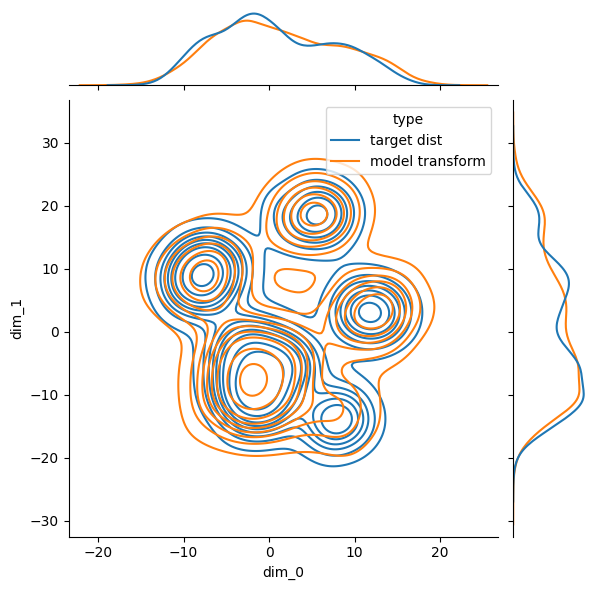

trail: 0 m step: 7 kl_test: 1.5308609008789062


  2%|▏         | 100/6000 [00:32<34:49,  2.82it/s]

trail: 0 m step: 8 Loss: 1.4491100311279297  L_n: 1.295949935913086  kld: 0.015316009521484375 KLD1: 1.2500700950622559 KLD2: 0.7707626819610596


  3%|▎         | 200/6000 [01:04<34:08,  2.83it/s]

trail: 0 m step: 8 Loss: 1.383352279663086  L_n: 1.230459213256836  kld: 0.015289306640625 KLD1: 1.2676301002502441 KLD2: 0.7653940916061401


  5%|▌         | 300/6000 [01:35<33:35,  2.83it/s]

trail: 0 m step: 8 Loss: 1.4793663024902344  L_n: 1.2874488830566406  kld: 0.019191741943359375 KLD1: 1.2368576526641846 KLD2: 0.7638275623321533


  7%|▋         | 400/6000 [02:07<33:00,  2.83it/s]

trail: 0 m step: 8 Loss: 1.3964271545410156  L_n: 1.2404441833496094  kld: 0.015598297119140625 KLD1: 1.2751696109771729 KLD2: 0.7524592876434326


  8%|▊         | 500/6000 [02:40<32:25,  2.83it/s]

trail: 0 m step: 8 Loss: 1.4268207550048828  L_n: 1.2666797637939453  kld: 0.01601409912109375 KLD1: 1.27693510055542 KLD2: 0.7562956809997559


 10%|█         | 600/6000 [03:12<31:54,  2.82it/s]

trail: 0 m step: 8 Loss: 1.4290542602539062  L_n: 1.2559814453125  kld: 0.017307281494140625 KLD1: 1.2486824989318848 KLD2: 0.745357871055603


 12%|█▏        | 700/6000 [03:44<31:20,  2.82it/s]

trail: 0 m step: 8 Loss: 1.4091663360595703  L_n: 1.228769302368164  kld: 0.018039703369140625 KLD1: 1.241424798965454 KLD2: 0.765428900718689


 13%|█▎        | 800/6000 [04:16<30:46,  2.82it/s]

trail: 0 m step: 8 Loss: 1.3980159759521484  L_n: 1.2250003814697266  kld: 0.017301559448242188 KLD1: 1.2790980339050293 KLD2: 0.7465354204177856


 15%|█▌        | 900/6000 [04:48<30:05,  2.83it/s]

trail: 0 m step: 8 Loss: 1.3700084686279297  L_n: 1.2169818878173828  kld: 0.015302658081054688 KLD1: 1.2660030126571655 KLD2: 0.7395876049995422


 17%|█▋        | 1000/6000 [05:20<29:33,  2.82it/s]

trail: 0 m step: 8 Loss: 1.4354743957519531  L_n: 1.2526931762695312  kld: 0.018278121948242188 KLD1: 1.2185817956924438 KLD2: 0.7451629638671875


 18%|█▊        | 1100/6000 [05:52<28:56,  2.82it/s]

trail: 0 m step: 8 Loss: 1.4102802276611328  L_n: 1.2629756927490234  kld: 0.014730453491210938 KLD1: 1.2513066530227661 KLD2: 0.7317877411842346


 20%|██        | 1200/6000 [06:24<28:21,  2.82it/s]

trail: 0 m step: 8 Loss: 1.3970375061035156  L_n: 1.2232589721679688  kld: 0.017377853393554688 KLD1: 1.2216922044754028 KLD2: 0.7403808236122131


 22%|██▏       | 1300/6000 [06:56<27:48,  2.82it/s]

trail: 0 m step: 8 Loss: 1.401205062866211  L_n: 1.2178325653076172  kld: 0.018337249755859375 KLD1: 1.194501280784607 KLD2: 0.7415265440940857


 23%|██▎       | 1400/6000 [07:28<27:14,  2.81it/s]

trail: 0 m step: 8 Loss: 1.4727859497070312  L_n: 1.2730293273925781  kld: 0.019975662231445312 KLD1: 1.2283471822738647 KLD2: 0.7433415651321411


 25%|██▌       | 1500/6000 [08:00<26:42,  2.81it/s]

trail: 0 m step: 8 Loss: 1.3830490112304688  L_n: 1.2113876342773438  kld: 0.0171661376953125 KLD1: 1.2366282939910889 KLD2: 0.7591642737388611


 27%|██▋       | 1600/6000 [08:32<25:59,  2.82it/s]

trail: 0 m step: 8 Loss: 1.4192733764648438  L_n: 1.2507972717285156  kld: 0.016847610473632812 KLD1: 1.2193046808242798 KLD2: 0.744144082069397


 28%|██▊       | 1700/6000 [09:04<25:26,  2.82it/s]

trail: 0 m step: 8 Loss: 1.3993091583251953  L_n: 1.241800308227539  kld: 0.015750885009765625 KLD1: 1.2417749166488647 KLD2: 0.737514317035675


 30%|███       | 1800/6000 [09:36<24:50,  2.82it/s]

trail: 0 m step: 8 Loss: 1.4217815399169922  L_n: 1.2277469635009766  kld: 0.019403457641601562 KLD1: 1.194795846939087 KLD2: 0.7592013478279114


 32%|███▏      | 1900/6000 [10:08<24:16,  2.82it/s]

trail: 0 m step: 8 Loss: 1.45989990234375  L_n: 1.2765464782714844  kld: 0.018335342407226562 KLD1: 1.2271718978881836 KLD2: 0.7823256254196167


 33%|███▎      | 2000/6000 [10:40<23:38,  2.82it/s]

trail: 0 m step: 8 Loss: 1.429738998413086  L_n: 1.252298355102539  kld: 0.017744064331054688 KLD1: 1.214805245399475 KLD2: 0.7446076273918152


 35%|███▌      | 2100/6000 [11:12<23:03,  2.82it/s]

trail: 0 m step: 8 Loss: 1.3936996459960938  L_n: 1.2561988830566406  kld: 0.013750076293945312 KLD1: 1.2544784545898438 KLD2: 0.7420510649681091


 37%|███▋      | 2200/6000 [11:45<22:29,  2.82it/s]

trail: 0 m step: 8 Loss: 1.3680419921875  L_n: 1.2056312561035156  kld: 0.016241073608398438 KLD1: 1.2380160093307495 KLD2: 0.7388994097709656


 38%|███▊      | 2300/6000 [12:17<21:54,  2.81it/s]

trail: 0 m step: 8 Loss: 1.3879261016845703  L_n: 1.2271747589111328  kld: 0.01607513427734375 KLD1: 1.2183525562286377 KLD2: 0.7548978328704834


 40%|████      | 2400/6000 [12:49<21:13,  2.83it/s]

trail: 0 m step: 8 Loss: 1.3735408782958984  L_n: 1.2202472686767578  kld: 0.015329360961914062 KLD1: 1.2319484949111938 KLD2: 0.7352689504623413


 42%|████▏     | 2500/6000 [13:21<20:38,  2.83it/s]

trail: 0 m step: 8 Loss: 1.3991031646728516  L_n: 1.225229263305664  kld: 0.01738739013671875 KLD1: 1.2050222158432007 KLD2: 0.741557776927948


 43%|████▎     | 2600/6000 [13:53<20:05,  2.82it/s]

trail: 0 m step: 8 Loss: 1.3845844268798828  L_n: 1.2170429229736328  kld: 0.016754150390625 KLD1: 1.19917631149292 KLD2: 0.7660350203514099


 45%|████▌     | 2700/6000 [14:25<19:31,  2.82it/s]

trail: 0 m step: 8 Loss: 1.4141960144042969  L_n: 1.2094993591308594  kld: 0.02046966552734375 KLD1: 1.1859865188598633 KLD2: 0.7413751482963562


 47%|████▋     | 2800/6000 [14:57<18:54,  2.82it/s]

trail: 0 m step: 8 Loss: 1.3726310729980469  L_n: 1.2563400268554688  kld: 0.011629104614257812 KLD1: 1.2602330446243286 KLD2: 0.7590054273605347


 48%|████▊     | 2900/6000 [15:29<18:17,  2.83it/s]

trail: 0 m step: 8 Loss: 1.4047298431396484  L_n: 1.1996707916259766  kld: 0.020505905151367188 KLD1: 1.1786094903945923 KLD2: 0.7517268061637878


 50%|█████     | 3000/6000 [16:01<17:42,  2.82it/s]

trail: 0 m step: 8 Loss: 1.3493881225585938  L_n: 1.1942253112792969  kld: 0.015516281127929688 KLD1: 1.2420270442962646 KLD2: 0.7434980273246765


 52%|█████▏    | 3100/6000 [16:33<17:05,  2.83it/s]

trail: 0 m step: 8 Loss: 1.3381023406982422  L_n: 1.2075061798095703  kld: 0.013059616088867188 KLD1: 1.2383910417556763 KLD2: 0.7413527369499207


 53%|█████▎    | 3200/6000 [17:05<16:34,  2.82it/s]

trail: 0 m step: 8 Loss: 1.391592025756836  L_n: 1.1971569061279297  kld: 0.019443511962890625 KLD1: 1.177523136138916 KLD2: 0.7463997006416321


 55%|█████▌    | 3300/6000 [17:37<16:00,  2.81it/s]

trail: 0 m step: 8 Loss: 1.3928585052490234  L_n: 1.221750259399414  kld: 0.017110824584960938 KLD1: 1.195404052734375 KLD2: 0.7440536022186279


 57%|█████▋    | 3400/6000 [18:09<15:23,  2.81it/s]

trail: 0 m step: 8 Loss: 1.4084949493408203  L_n: 1.2690868377685547  kld: 0.013940811157226562 KLD1: 1.2506858110427856 KLD2: 0.7462912201881409


 58%|█████▊    | 3500/6000 [18:41<14:48,  2.81it/s]

trail: 0 m step: 8 Loss: 1.3538398742675781  L_n: 1.2103118896484375  kld: 0.014352798461914062 KLD1: 1.2234253883361816 KLD2: 0.7427545189857483


 60%|██████    | 3600/6000 [19:13<14:12,  2.82it/s]

trail: 0 m step: 8 Loss: 1.3705921173095703  L_n: 1.2137126922607422  kld: 0.015687942504882812 KLD1: 1.2340279817581177 KLD2: 0.7605303525924683


 62%|██████▏   | 3700/6000 [19:45<13:34,  2.82it/s]

trail: 0 m step: 8 Loss: 1.35992431640625  L_n: 1.1995162963867188  kld: 0.016040802001953125 KLD1: 1.2168971300125122 KLD2: 0.7414941191673279


 63%|██████▎   | 3800/6000 [20:17<13:01,  2.81it/s]

trail: 0 m step: 8 Loss: 1.3718280792236328  L_n: 1.2083301544189453  kld: 0.01634979248046875 KLD1: 1.2269327640533447 KLD2: 0.7578201293945312


 65%|██████▌   | 3900/6000 [20:49<12:24,  2.82it/s]

trail: 0 m step: 8 Loss: 1.423929214477539  L_n: 1.2448863983154297  kld: 0.017904281616210938 KLD1: 1.1750245094299316 KLD2: 0.7523133754730225


 67%|██████▋   | 4000/6000 [21:21<11:50,  2.81it/s]

trail: 0 m step: 8 Loss: 1.3731670379638672  L_n: 1.2227535247802734  kld: 0.015041351318359375 KLD1: 1.2279267311096191 KLD2: 0.7421189546585083


 68%|██████▊   | 4100/6000 [21:53<11:12,  2.82it/s]

trail: 0 m step: 8 Loss: 1.323944091796875  L_n: 1.2017593383789062  kld: 0.012218475341796875 KLD1: 1.254602074623108 KLD2: 0.7565624117851257


 70%|███████   | 4200/6000 [22:25<10:39,  2.81it/s]

trail: 0 m step: 8 Loss: 1.3334274291992188  L_n: 1.1836814880371094  kld: 0.014974594116210938 KLD1: 1.233516812324524 KLD2: 0.7609778046607971


 72%|███████▏  | 4300/6000 [22:57<10:02,  2.82it/s]

trail: 0 m step: 8 Loss: 1.3659286499023438  L_n: 1.1957550048828125  kld: 0.017017364501953125 KLD1: 1.2069000005722046 KLD2: 0.7437537908554077


 73%|███████▎  | 4400/6000 [23:29<09:26,  2.82it/s]

trail: 0 m step: 8 Loss: 1.4107685089111328  L_n: 1.243722915649414  kld: 0.016704559326171875 KLD1: 1.2157784700393677 KLD2: 0.743397057056427


 75%|███████▌  | 4500/6000 [24:02<08:51,  2.82it/s]

trail: 0 m step: 8 Loss: 1.3718242645263672  L_n: 1.2064189910888672  kld: 0.01654052734375 KLD1: 1.2121306657791138 KLD2: 0.7491477727890015


 77%|███████▋  | 4600/6000 [24:34<08:16,  2.82it/s]

trail: 0 m step: 8 Loss: 1.34698486328125  L_n: 1.1831626892089844  kld: 0.016382217407226562 KLD1: 1.2188206911087036 KLD2: 0.7512784004211426


 78%|███████▊  | 4700/6000 [25:06<07:41,  2.82it/s]

trail: 0 m step: 8 Loss: 1.387786865234375  L_n: 1.2070655822753906  kld: 0.018072128295898438 KLD1: 1.1956534385681152 KLD2: 0.7491071224212646


 80%|████████  | 4800/6000 [25:38<07:06,  2.82it/s]

trail: 0 m step: 8 Loss: 1.35870361328125  L_n: 1.2125244140625  kld: 0.014617919921875 KLD1: 1.2051690816879272 KLD2: 0.7321085333824158


 82%|████████▏ | 4900/6000 [26:10<06:29,  2.83it/s]

trail: 0 m step: 8 Loss: 1.3901290893554688  L_n: 1.239105224609375  kld: 0.015102386474609375 KLD1: 1.2108057737350464 KLD2: 0.7278835773468018


 83%|████████▎ | 5000/6000 [26:42<05:54,  2.82it/s]

trail: 0 m step: 8 Loss: 1.3634471893310547  L_n: 1.2039356231689453  kld: 0.015951156616210938 KLD1: 1.219482421875 KLD2: 0.7318156957626343


 85%|████████▌ | 5100/6000 [27:14<05:18,  2.82it/s]

trail: 0 m step: 8 Loss: 1.3766365051269531  L_n: 1.2157516479492188  kld: 0.016088485717773438 KLD1: 1.1979470252990723 KLD2: 0.755565345287323


 87%|████████▋ | 5200/6000 [27:46<04:43,  2.83it/s]

trail: 0 m step: 8 Loss: 1.3772525787353516  L_n: 1.2020244598388672  kld: 0.017522811889648438 KLD1: 1.222622275352478 KLD2: 0.7374379634857178


 88%|████████▊ | 5300/6000 [28:18<04:08,  2.81it/s]

trail: 0 m step: 8 Loss: 1.3950366973876953  L_n: 1.231710433959961  kld: 0.016332626342773438 KLD1: 1.2047919034957886 KLD2: 0.7331858277320862


 90%|█████████ | 5400/6000 [28:50<03:32,  2.82it/s]

trail: 0 m step: 8 Loss: 1.3667716979980469  L_n: 1.2107124328613281  kld: 0.015605926513671875 KLD1: 1.1947215795516968 KLD2: 0.7558392286300659


 92%|█████████▏| 5500/6000 [29:22<02:57,  2.82it/s]

trail: 0 m step: 8 Loss: 1.3791465759277344  L_n: 1.2195587158203125  kld: 0.015958786010742188 KLD1: 1.226818323135376 KLD2: 0.7323256731033325


 93%|█████████▎| 5600/6000 [29:55<02:22,  2.82it/s]

trail: 0 m step: 8 Loss: 1.4097328186035156  L_n: 1.2255401611328125  kld: 0.018419265747070312 KLD1: 1.1812529563903809 KLD2: 0.7382766604423523


 95%|█████████▌| 5700/6000 [30:27<01:46,  2.81it/s]

trail: 0 m step: 8 Loss: 1.3567008972167969  L_n: 1.1875190734863281  kld: 0.016918182373046875 KLD1: 1.1711044311523438 KLD2: 0.7406724095344543


 97%|█████████▋| 5800/6000 [30:59<01:11,  2.82it/s]

trail: 0 m step: 8 Loss: 1.376363754272461  L_n: 1.2050647735595703  kld: 0.017129898071289062 KLD1: 1.1900012493133545 KLD2: 0.7304139733314514


 98%|█████████▊| 5900/6000 [31:31<00:35,  2.81it/s]

trail: 0 m step: 8 Loss: 1.4182929992675781  L_n: 1.2072257995605469  kld: 0.021106719970703125 KLD1: 1.1474689245224 KLD2: 0.7431392669677734


100%|██████████| 6000/6000 [32:03<00:00,  3.12it/s]

trail: 0 m step: 8 Loss: 1.3664989471435547  L_n: 1.2089519500732422  kld: 0.01575469970703125 KLD1: 1.2042797803878784 KLD2: 0.7448126673698425



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


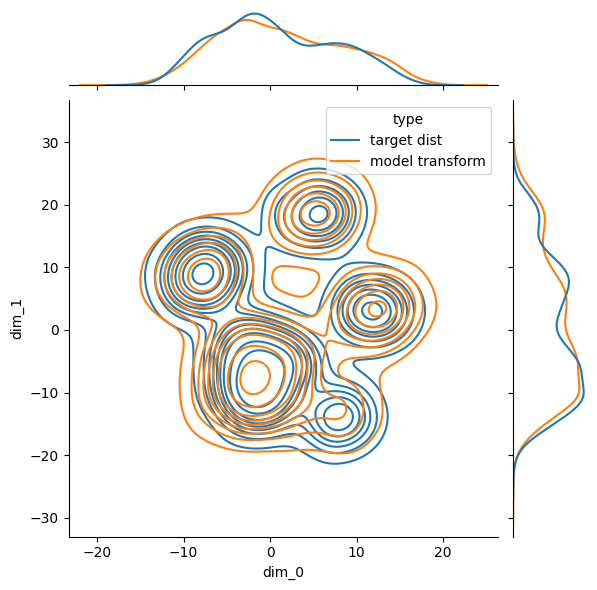

trail: 0 m step: 8 kl_test: 1.2092018127441406


  2%|▏         | 100/6000 [00:31<34:57,  2.81it/s]

trail: 0 m step: 9 Loss: 1.145578384399414  L_n: 1.0295352935791016  kld: 0.01160430908203125 KLD1: 0.98145991563797 KLD2: 0.6395653486251831


  3%|▎         | 200/6000 [01:04<34:12,  2.83it/s]

trail: 0 m step: 9 Loss: 1.1117115020751953  L_n: 0.9776058197021484  kld: 0.013410568237304688 KLD1: 0.9906682372093201 KLD2: 0.6370490193367004


  5%|▌         | 300/6000 [01:36<33:24,  2.84it/s]

trail: 0 m step: 9 Loss: 1.1724586486816406  L_n: 1.0233802795410156  kld: 0.0149078369140625 KLD1: 0.9882045388221741 KLD2: 0.6411840915679932


  7%|▋         | 400/6000 [02:07<33:00,  2.83it/s]

trail: 0 m step: 9 Loss: 1.1227874755859375  L_n: 0.9953193664550781  kld: 0.012746810913085938 KLD1: 1.0017552375793457 KLD2: 0.6203937530517578


  8%|▊         | 500/6000 [02:39<32:27,  2.82it/s]

trail: 0 m step: 9 Loss: 1.1224861145019531  L_n: 1.0075874328613281  kld: 0.0114898681640625 KLD1: 1.0302484035491943 KLD2: 0.6251742839813232


 10%|█         | 600/6000 [03:11<31:47,  2.83it/s]

trail: 0 m step: 9 Loss: 1.143594741821289  L_n: 1.013875961303711  kld: 0.012971878051757812 KLD1: 0.9985610842704773 KLD2: 0.6144450306892395


 12%|█▏        | 700/6000 [03:43<31:16,  2.82it/s]

trail: 0 m step: 9 Loss: 1.1516799926757812  L_n: 0.9999313354492188  kld: 0.01517486572265625 KLD1: 1.0003470182418823 KLD2: 0.6333947777748108


 13%|█▎        | 800/6000 [04:15<30:40,  2.82it/s]

trail: 0 m step: 9 Loss: 1.1085948944091797  L_n: 0.9835491180419922  kld: 0.01250457763671875 KLD1: 1.0205882787704468 KLD2: 0.6194277405738831


 15%|█▌        | 900/6000 [04:47<30:08,  2.82it/s]

trail: 0 m step: 9 Loss: 1.0975780487060547  L_n: 0.9752979278564453  kld: 0.012228012084960938 KLD1: 1.0013409852981567 KLD2: 0.6083186268806458


 17%|█▋        | 1000/6000 [05:19<29:32,  2.82it/s]

trail: 0 m step: 9 Loss: 1.1538333892822266  L_n: 1.0010547637939453  kld: 0.015277862548828125 KLD1: 0.9912793636322021 KLD2: 0.6183546185493469


 18%|█▊        | 1100/6000 [05:52<28:55,  2.82it/s]

trail: 0 m step: 9 Loss: 1.1112098693847656  L_n: 1.0009078979492188  kld: 0.011030197143554688 KLD1: 0.9928829669952393 KLD2: 0.6061741709709167


 20%|██        | 1200/6000 [06:24<28:17,  2.83it/s]

trail: 0 m step: 9 Loss: 1.1367416381835938  L_n: 0.9975433349609375  kld: 0.013919830322265625 KLD1: 0.9490833878517151 KLD2: 0.6149007081985474


 22%|██▏       | 1300/6000 [06:56<27:45,  2.82it/s]

trail: 0 m step: 9 Loss: 1.1403312683105469  L_n: 0.970977783203125  kld: 0.016935348510742188 KLD1: 0.9520265460014343 KLD2: 0.6088314056396484


 23%|██▎       | 1400/6000 [07:28<27:11,  2.82it/s]

trail: 0 m step: 9 Loss: 1.173685073852539  L_n: 1.0055713653564453  kld: 0.016811370849609375 KLD1: 0.9727159738540649 KLD2: 0.6043673753738403


 25%|██▌       | 1500/6000 [08:00<26:37,  2.82it/s]

trail: 0 m step: 9 Loss: 1.1282539367675781  L_n: 0.9860610961914062  kld: 0.014219284057617188 KLD1: 0.9547579884529114 KLD2: 0.626739501953125


 27%|██▋       | 1600/6000 [08:32<25:58,  2.82it/s]

trail: 0 m step: 9 Loss: 1.1481494903564453  L_n: 1.0121936798095703  kld: 0.0135955810546875 KLD1: 0.9859535098075867 KLD2: 0.6205238103866577


 28%|██▊       | 1700/6000 [09:04<25:22,  2.83it/s]

trail: 0 m step: 9 Loss: 1.0965137481689453  L_n: 0.9657840728759766  kld: 0.013072967529296875 KLD1: 0.9918124675750732 KLD2: 0.6014728546142578


 30%|███       | 1800/6000 [09:36<24:49,  2.82it/s]

trail: 0 m step: 9 Loss: 1.147857666015625  L_n: 0.9820709228515625  kld: 0.01657867431640625 KLD1: 0.9595804214477539 KLD2: 0.6291878819465637


 32%|███▏      | 1900/6000 [10:08<24:10,  2.83it/s]

trail: 0 m step: 9 Loss: 1.1400890350341797  L_n: 0.9872531890869141  kld: 0.015283584594726562 KLD1: 0.9659906029701233 KLD2: 0.6467294692993164


 33%|███▎      | 2000/6000 [10:40<23:31,  2.83it/s]

trail: 0 m step: 9 Loss: 1.1315536499023438  L_n: 0.9940910339355469  kld: 0.013746261596679688 KLD1: 0.9806787967681885 KLD2: 0.6132308840751648


 35%|███▌      | 2100/6000 [11:12<22:59,  2.83it/s]

trail: 0 m step: 9 Loss: 1.0992603302001953  L_n: 0.9997920989990234  kld: 0.009946823120117188 KLD1: 1.0059788227081299 KLD2: 0.6156044006347656


 37%|███▋      | 2200/6000 [11:44<22:18,  2.84it/s]

trail: 0 m step: 9 Loss: 1.0799369812011719  L_n: 0.9506950378417969  kld: 0.0129241943359375 KLD1: 0.9789296388626099 KLD2: 0.6132300496101379


 38%|███▊      | 2300/6000 [12:16<21:45,  2.83it/s]

trail: 0 m step: 9 Loss: 1.1052989959716797  L_n: 0.9883785247802734  kld: 0.011692047119140625 KLD1: 0.9687468409538269 KLD2: 0.6287380456924438


 40%|████      | 2400/6000 [12:48<21:13,  2.83it/s]

trail: 0 m step: 9 Loss: 1.0553321838378906  L_n: 0.9538803100585938  kld: 0.010145187377929688 KLD1: 0.998251736164093 KLD2: 0.6153638362884521


 42%|████▏     | 2500/6000 [13:20<20:34,  2.83it/s]

trail: 0 m step: 9 Loss: 1.1127662658691406  L_n: 0.9801864624023438  kld: 0.013257980346679688 KLD1: 0.9721291661262512 KLD2: 0.6168340444564819


 43%|████▎     | 2600/6000 [13:52<20:00,  2.83it/s]

trail: 0 m step: 9 Loss: 1.1053638458251953  L_n: 0.9793071746826172  kld: 0.012605667114257812 KLD1: 0.9829816222190857 KLD2: 0.639217734336853


 45%|████▌     | 2700/6000 [14:24<19:28,  2.82it/s]

trail: 0 m step: 9 Loss: 1.1313457489013672  L_n: 0.9746761322021484  kld: 0.015666961669921875 KLD1: 0.9380196928977966 KLD2: 0.6130995154380798


 47%|████▋     | 2800/6000 [14:56<18:49,  2.83it/s]

trail: 0 m step: 9 Loss: 1.109689712524414  L_n: 1.0267009735107422  kld: 0.008298873901367188 KLD1: 1.0152480602264404 KLD2: 0.634152889251709


 48%|████▊     | 2900/6000 [15:28<18:18,  2.82it/s]

trail: 0 m step: 9 Loss: 1.1210899353027344  L_n: 0.9467391967773438  kld: 0.017435073852539062 KLD1: 0.9399694800376892 KLD2: 0.6237010955810547


 50%|█████     | 3000/6000 [16:00<17:42,  2.82it/s]

trail: 0 m step: 9 Loss: 1.0771713256835938  L_n: 0.9663734436035156  kld: 0.011079788208007812 KLD1: 0.9969602227210999 KLD2: 0.6199604868888855


 52%|█████▏    | 3100/6000 [16:32<17:06,  2.83it/s]

trail: 0 m step: 9 Loss: 1.0552978515625  L_n: 0.9605598449707031  kld: 0.009473800659179688 KLD1: 1.018168330192566 KLD2: 0.6165565252304077


 53%|█████▎    | 3200/6000 [17:04<16:29,  2.83it/s]

trail: 0 m step: 9 Loss: 1.0976333618164062  L_n: 0.9467620849609375  kld: 0.015087127685546875 KLD1: 0.9495108127593994 KLD2: 0.6153596043586731


 55%|█████▌    | 3300/6000 [17:36<15:56,  2.82it/s]

trail: 0 m step: 9 Loss: 1.1049880981445312  L_n: 0.9734764099121094  kld: 0.013151168823242188 KLD1: 0.9595339894294739 KLD2: 0.6156752109527588


 57%|█████▋    | 3400/6000 [18:08<15:23,  2.82it/s]

trail: 0 m step: 9 Loss: 1.1230754852294922  L_n: 1.0068035125732422  kld: 0.011627197265625 KLD1: 1.0031542778015137 KLD2: 0.6176836490631104


 58%|█████▊    | 3500/6000 [18:40<14:46,  2.82it/s]

trail: 0 m step: 9 Loss: 1.08074951171875  L_n: 0.9707908630371094  kld: 0.010995864868164062 KLD1: 0.9916529059410095 KLD2: 0.6155107021331787


 60%|██████    | 3600/6000 [19:12<14:08,  2.83it/s]

trail: 0 m step: 9 Loss: 1.0851268768310547  L_n: 0.9677486419677734  kld: 0.011737823486328125 KLD1: 0.9814416766166687 KLD2: 0.6311808228492737


 62%|██████▏   | 3700/6000 [19:44<13:36,  2.82it/s]

trail: 0 m step: 9 Loss: 1.0916614532470703  L_n: 0.9755229949951172  kld: 0.011613845825195312 KLD1: 0.9893508553504944 KLD2: 0.6183724999427795


 63%|██████▎   | 3800/6000 [20:16<12:56,  2.83it/s]

trail: 0 m step: 9 Loss: 1.0692863464355469  L_n: 0.946929931640625  kld: 0.012235641479492188 KLD1: 0.9842297434806824 KLD2: 0.6304944753646851


 65%|██████▌   | 3900/6000 [20:48<12:24,  2.82it/s]

trail: 0 m step: 9 Loss: 1.1292724609375  L_n: 0.9993438720703125  kld: 0.01299285888671875 KLD1: 0.9450052380561829 KLD2: 0.6235036253929138


 67%|██████▋   | 4000/6000 [21:20<11:48,  2.82it/s]

trail: 0 m step: 9 Loss: 1.0897712707519531  L_n: 0.98065185546875  kld: 0.010911941528320312 KLD1: 0.9693977236747742 KLD2: 0.6142411231994629


 68%|██████▊   | 4100/6000 [21:52<11:13,  2.82it/s]

trail: 0 m step: 9 Loss: 1.058969497680664  L_n: 0.9688472747802734  kld: 0.009012222290039062 KLD1: 1.0087522268295288 KLD2: 0.6239505410194397


 70%|███████   | 4200/6000 [22:24<10:38,  2.82it/s]

trail: 0 m step: 9 Loss: 1.0636310577392578  L_n: 0.9466533660888672  kld: 0.011697769165039062 KLD1: 0.9648329615592957 KLD2: 0.6332195401191711


 72%|███████▏  | 4300/6000 [22:56<10:01,  2.83it/s]

trail: 0 m step: 9 Loss: 1.081502914428711  L_n: 0.9558658599853516  kld: 0.012563705444335938 KLD1: 0.9724833965301514 KLD2: 0.6182125806808472


 73%|███████▎  | 4400/6000 [23:28<09:27,  2.82it/s]

trail: 0 m step: 9 Loss: 1.1109638214111328  L_n: 0.9938907623291016  kld: 0.011707305908203125 KLD1: 0.9676801562309265 KLD2: 0.6156388521194458


 75%|███████▌  | 4500/6000 [24:00<08:51,  2.82it/s]

trail: 0 m step: 9 Loss: 1.0910415649414062  L_n: 0.9680366516113281  kld: 0.012300491333007812 KLD1: 0.9745737910270691 KLD2: 0.6180594563484192


 77%|███████▋  | 4600/6000 [24:32<08:16,  2.82it/s]

trail: 0 m step: 9 Loss: 1.0675907135009766  L_n: 0.9417057037353516  kld: 0.0125885009765625 KLD1: 0.9524238109588623 KLD2: 0.619652509689331


 78%|███████▊  | 4700/6000 [25:04<07:39,  2.83it/s]

trail: 0 m step: 9 Loss: 1.0922260284423828  L_n: 0.9486408233642578  kld: 0.0143585205078125 KLD1: 0.9666991829872131 KLD2: 0.6194835901260376


 80%|████████  | 4800/6000 [25:36<07:05,  2.82it/s]

trail: 0 m step: 9 Loss: 1.0649261474609375  L_n: 0.9560356140136719  kld: 0.010889053344726562 KLD1: 0.9664064049720764 KLD2: 0.6058746576309204


 82%|████████▏ | 4900/6000 [26:08<06:29,  2.82it/s]

trail: 0 m step: 9 Loss: 1.1023788452148438  L_n: 0.9869842529296875  kld: 0.011539459228515625 KLD1: 0.9813087582588196 KLD2: 0.6009000539779663


 83%|████████▎ | 5000/6000 [26:40<05:54,  2.82it/s]

trail: 0 m step: 9 Loss: 1.0826263427734375  L_n: 0.9615478515625  kld: 0.01210784912109375 KLD1: 0.9826084971427917 KLD2: 0.6044391989707947


 85%|████████▌ | 5100/6000 [27:12<05:18,  2.82it/s]

trail: 0 m step: 9 Loss: 1.0786190032958984  L_n: 0.9571018218994141  kld: 0.012151718139648438 KLD1: 0.950512170791626 KLD2: 0.6254494190216064


 87%|████████▋ | 5200/6000 [27:44<04:42,  2.84it/s]

trail: 0 m step: 9 Loss: 1.1172828674316406  L_n: 0.9774360656738281  kld: 0.01398468017578125 KLD1: 0.960888147354126 KLD2: 0.6118035912513733


 88%|████████▊ | 5300/6000 [28:16<04:08,  2.82it/s]

trail: 0 m step: 9 Loss: 1.061431884765625  L_n: 0.9494895935058594  kld: 0.011194229125976562 KLD1: 0.9840593338012695 KLD2: 0.6064959764480591


 90%|█████████ | 5400/6000 [28:48<03:32,  2.83it/s]

trail: 0 m step: 9 Loss: 1.072000503540039  L_n: 0.9419765472412109  kld: 0.013002395629882812 KLD1: 0.9296384453773499 KLD2: 0.6265442371368408


 92%|█████████▏| 5500/6000 [29:20<02:57,  2.82it/s]

trail: 0 m step: 9 Loss: 1.0880451202392578  L_n: 0.9688167572021484  kld: 0.011922836303710938 KLD1: 0.9749240279197693 KLD2: 0.6021307706832886


 93%|█████████▎| 5600/6000 [29:52<02:21,  2.83it/s]

trail: 0 m step: 9 Loss: 1.1152629852294922  L_n: 0.9705715179443359  kld: 0.014469146728515625 KLD1: 0.9283376932144165 KLD2: 0.6099675893783569


 95%|█████████▌| 5700/6000 [30:24<01:46,  2.82it/s]

trail: 0 m step: 9 Loss: 1.0746955871582031  L_n: 0.9416007995605469  kld: 0.013309478759765625 KLD1: 0.9392593502998352 KLD2: 0.6139134168624878


 97%|█████████▋| 5800/6000 [30:56<01:11,  2.82it/s]

trail: 0 m step: 9 Loss: 1.0820026397705078  L_n: 0.9503765106201172  kld: 0.013162612915039062 KLD1: 0.9489482045173645 KLD2: 0.602681040763855


 98%|█████████▊| 5900/6000 [31:28<00:35,  2.82it/s]

trail: 0 m step: 9 Loss: 1.1185150146484375  L_n: 0.9544830322265625  kld: 0.0164031982421875 KLD1: 0.9264386296272278 KLD2: 0.6154962778091431


100%|██████████| 6000/6000 [32:00<00:00,  3.12it/s]

trail: 0 m step: 9 Loss: 1.0651168823242188  L_n: 0.9481010437011719  kld: 0.011701583862304688 KLD1: 0.9376298785209656 KLD2: 0.6138308644294739



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


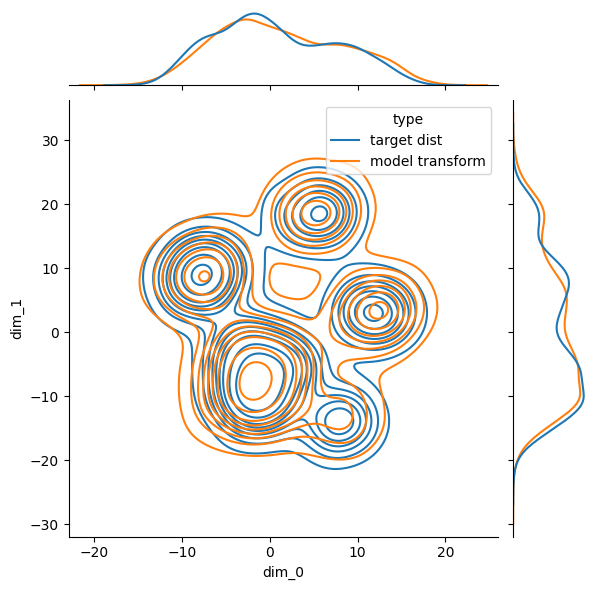

trail: 0 m step: 9 kl_test: 0.9583168029785156


In [ ]:
for mirror_itr in range(n_max_mirror_iterations):
  flows = []
  for i in range(num_layers):
      param_map = nf.nets.MLP([int(dim/2), width, width, width, dim], init_zeros=True )
      flows.append(nf.flows.AffineCouplingBlock(param_map))
      flows.append(nf.flows.Permute(dim, mode='swap'))

  # for i in range(num_layers):
  #     flows += [nf.flows.AutoregressiveRationalQuadraticSpline(dim, 2, width)]
  #     flows += [nf.flows.LULinearPermute(dim)]

  model2 = nf.NormalizingFlow(base, flows, stationary_dist).to(device)
  model2.load_state_dict(model.state_dict())
  optimizer_lr_input = optimizer_lr * (outer_lr_factor**mirror_itr)
  optimizer = torch.optim.Adam(model2.parameters(), lr=optimizer_lr_input, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

  input_eta = eta
  for it in tqdm(range(n_max_iterations), disable = not verbose):
    model2 = model2.train()
    optimizer.zero_grad()
    # torch.manual_seed(set_seed + trail_num)
    z = base.sample(num_samples)
    log_prob_rho_0 = base.log_prob(z)
    sampled_theta, log_det_model = model2.forward_and_log_det(z)
    log_prob_model = log_prob_rho_0 - log_det_model
    log_prob_prev = model.log_prob(sampled_theta)

    L_n_loss =  model2.reverse_kld(num_samples=num_samples)
    kld_loss = torch.mean(log_prob_model).to(torch.double) - torch.mean(log_prob_prev).to(torch.double)
    kld_loss = kld_loss if kld_loss.item() >= 0 else torch.tensor([0.0]).to(device)
    kld_loss = kld_loss if kld_loss.item() <= 500 else torch.tensor([500.0]).to(device)
    loss = L_n_loss   + (1/input_eta)*kld_loss

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      scheduler.step()


    if verbose:
      if it % 100 == 99:
        with torch.no_grad():
          model2.eval()
          target_samples = stationary_dist.sample((num_samples,))
          temp1 = model2.log_prob(sampled_theta) - stationary_dist.log_prob(sampled_theta)
          temp2 = stationary_dist.log_prob(target_samples) - model2.log_prob(target_samples)
        kld_1 = torch.mean(temp1)
        kld_2 = torch.mean(temp2)
        print('trail:',trail_num,'m step:',mirror_itr,'Loss:', loss.item(), ' L_n:', L_n_loss.item() , ' kld:',kld_loss.item(), 'KLD1:', kld_1.item(), 'KLD2:', kld_2.item()  )

  model.load_state_dict(model2.state_dict())
  kld1_hist = np.append(kld1_hist, kld_1.to('cpu').data.numpy())
  kld2_hist = np.append(kld2_hist, kld_2.to('cpu').data.numpy())
  with torch.no_grad():
    model.eval()
    target_samples = stationary_dist.sample((5000,))
    model_samples, _ = model.sample(5000)
    kl_test = model2.reverse_kld(num_samples=num_samples_test)
    kl_test = kl_test.cpu().detach()
  plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())
  plt.show()
  print('trail:',trail_num,'m step:',mirror_itr,'kl_test:', kl_test.item()   )


<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


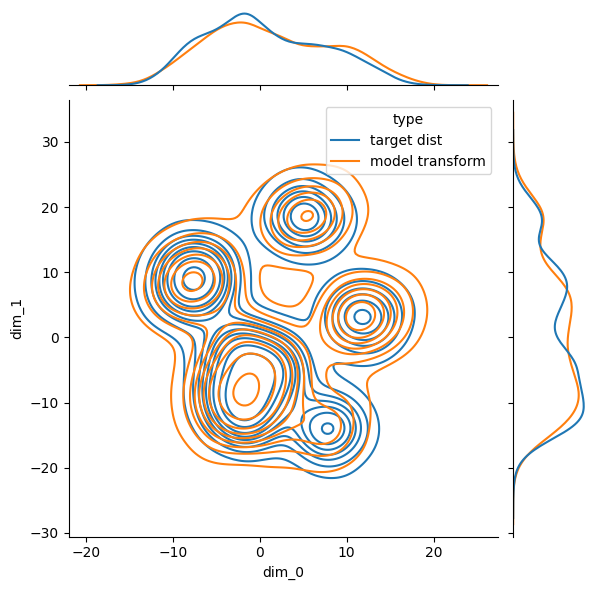

In [ ]:
target_samples = stationary_dist.sample((5000,))
model_samples, _ = model.sample(5000)
plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())

In [ ]:
for mirror_itr in range(n_max_mirror_iterations):
  flows = []
  for i in range(num_layers):
      param_map = nf.nets.MLP([int(dim/2), width, width, width, dim], init_zeros=True )
      flows.append(nf.flows.AffineCouplingBlock(param_map))
      flows.append(nf.flows.Permute(dim, mode='swap'))

  # for i in range(num_layers):
  #     flows += [nf.flows.AutoregressiveRationalQuadraticSpline(dim, 2, width)]
  #     flows += [nf.flows.LULinearPermute(dim)]

  model2 = nf.NormalizingFlow(base, flows, stationary_dist).to(device)
  model2.load_state_dict(model.state_dict())
  optimizer = torch.optim.Adam(model2.parameters(), lr=1e-5, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

  input_eta = (eta*(1.3**mirror_itr))
  for it in tqdm(range(n_max_iterations), disable = not verbose):
    model2 = model2.train()
    optimizer.zero_grad()
    # torch.manual_seed(set_seed + trail_num)
    z = base.sample(num_samples)
    log_prob_rho_0 = base.log_prob(z)
    sampled_theta, log_det_model = model2.forward_and_log_det(z)
    log_prob_model = log_prob_rho_0 - log_det_model
    log_prob_prev = model.log_prob(sampled_theta)

    L_n_loss =  model2.reverse_kld(num_samples=num_samples)
    kld_loss = torch.mean(log_prob_model).to(torch.double) - torch.mean(log_prob_prev).to(torch.double)
    kld_loss = kld_loss if kld_loss.item() >= 0 else torch.tensor([0.0]).to(device)
    kld_loss = kld_loss if kld_loss.item() <= 500 else torch.tensor([500.0]).to(device)
    loss = L_n_loss   + (1/input_eta)*kld_loss

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      scheduler.step()


    if verbose:
      if it % 100 == 99:
        with torch.no_grad():
          model2.eval()
          target_samples = stationary_dist.sample((num_samples,))
          temp1 = model2.log_prob(sampled_theta) - stationary_dist.log_prob(sampled_theta)
          temp2 = stationary_dist.log_prob(target_samples) - model2.log_prob(target_samples)
        kld_1 = torch.mean(temp1)
        kld_2 = torch.mean(temp2)
        print('trail:',trail_num,'m step:',mirror_itr,'Loss:', loss.item(), ' L_n:', L_n_loss.item() , ' kld:',kld_loss.item(), 'KLD1:', kld_1.item(), 'KLD2:', kld_2.item()  )

  model.load_state_dict(model2.state_dict())
  kld1_hist = np.append(kld1_hist, kld_1.to('cpu').data.numpy())
  kld2_hist = np.append(kld2_hist, kld_2.to('cpu').data.numpy())
  with torch.no_grad():
    model.eval()
    target_samples = stationary_dist.sample((5000,))
    model_samples, _ = model.sample(5000)
    kl_test = model2.reverse_kld(num_samples=num_samples_test)
    kl_test = kl_test.cpu().detach()
  plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())
  plt.show()
  print('trail:',trail_num,'m step:',mirror_itr,'kl_test:', kl_test.item()   )

Output hidden; open in https://colab.research.google.com to view.